# Smart Cities - Reducing the Frequency of Fatal Road Accidents in the City of Toronto

In [1]:
# Install Libraries
!pip install pandas --upgrade
!pip install numpy
!pip install sklearn
!pip install geopy
!pip install BeautifulSoup4
!pip install imblearn
!pip install xgboost
# Geopandas library is used and it must be install using Anaconda Prompt by entering the following code: 
# conda install -c conda-forge geopandas
# Must restart Jupyter Notebook upon installing Geopandas

Requirement already up-to-date: pandas in c:\users\skynet\anaconda3\lib\site-packages (0.23.4)


In [2]:
#Import libraries
import pandas as pd
import numpy as np 
import string #string operations
import re #regular expression operations
import matplotlib.pyplot as plt
import seaborn as sns
import xml.etree.ElementTree as ET
from math import sin, cos, sqrt, atan2, radians
import geopy.distance
from scipy.spatial import distance
from geopy.geocoders import Nominatim
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
import geopandas as gpd
from zipfile import ZipFile
from shapely import geometry as geo
from shapely.geometry import Point, Polygon, shape
from shapely.geometry.polygon import Polygon
import shapefile
from xgboost import XGBClassifier
from scipy import stats

# Severity and Location of Accidents within the City of Toronto

The purpose of this project is to explore and answer the research question:

Where should resources be deployed to reduce fatalities by motor vehicles in urban centres?

The project has two components: (1) classifying if an accident will be severe (fatal) or non-severe (non-fatal) and (2) predicting the number of accidents to occur at a given intersection. For the purposes of the report and presentation, only the classification of accidents is shown as the prediction of accident numbers led to inconclusive results. The following technical report is broken into five sections, Data Gathering and Cleaning, Model/Data Preparation, Exploratory Analysis, Model Implementation and Discussion. Each section has descriptions associated with the code as well as comments for specifc lines of code. For more information on the business case for the project, please refer to the accompanying report.

# A. Data Gathering and Cleaning

Datasets used in this analysis are imported and cleaned. Every dataset is described and its attributes are mentinoned. The dataset link is attached as a reference.


### Pedestrian and Car volume
Data: This dataset contains the most recent 8 peak hour vehicle and pedestrian volume counts collected at intersections where there are traffic signals.  The data is typically collected between the hours of 7:30 a.m. and 6:00 p.m. for 2011 and 2018.

Source: https://www.toronto.ca/city-government/data-research-maps/open-data/open-data-catalogue/transportation/#7c8e7c62-7630-8b0f-43ed-a2dfe24aadc9

Attributes: The main attributes are Main Street, Side street, Total vehicle volume during 8 peak hours, and Total pedestrian volume during the 8 peak hours.


In [3]:
#Import intersection data that all other data with merge to
street_data = pd.read_excel('8hrVeh_PedVolume_6-Mar-2018.xlsx', encoding = 'utf8')

### TTC Streetcar data

Data: TTC Routes and Schedules

Source: City of Toronto Government Data – Transportation – Data Catalogue:

https://www.toronto.ca/city-government/data-research-maps/open-data/open-data-catalogue/transportation/

Attribute: The data provides multiple .csv files for all of the routes and schedules for the TTC. The data that was of significance was a series of coordinates (latitude/longitude), and an associated ‘Shape ID’ that allowed for the creation of shapes (lines) for the streetcar routes, so that they could be evaluated against the list of intersections.

In [4]:
# Open TTC streetcar shape files
with open('shapes.txt') as shapes:
    df_shapes = pd.read_csv(shapes)

In [5]:
# Open TTC trips file
with open('trips.txt') as trips:
    df_trips = pd.read_csv(trips)

In [6]:
#Open TTC routes file
with open('routes.txt') as routes:
    df_routes = pd.read_csv(routes)

In [7]:
# Filtering out shape IDs for streetcars
route_type_list = [0] # 0 for streetcars, 3 for buses
df_routes_filter = df_routes[df_routes['route_type'].isin(route_type_list)]
route_id_list = df_routes_filter.route_id.values.tolist()
df_trips_filter = df_trips[df_trips['route_id'].isin(route_id_list)]
shapes_set = set(df_trips_filter.shape_id.values.tolist())

In [8]:
#Create Geo Dataframe for TTC Streetcar routes
geometry = [geo.Point(xy) for xy in zip(df_shapes.shape_pt_lon, df_shapes.shape_pt_lat)]
gdf = gpd.GeoDataFrame(df_shapes, geometry=geometry)

In [9]:
#Generate LineStrings for TTC Streetcar routes
gdf = df_shapes.groupby(['shape_id'])['geometry'].apply(lambda x: geo.LineString(x.tolist()))
gdf = gpd.GeoDataFrame(gdf, geometry='geometry')

In [10]:
#Set index
gdf['shape_id'] = gdf.index

In [11]:
#Check if shape_id is contained in TTC streetcar routes shape_ids
gdf = gdf[gdf['shape_id'].isin(shapes_set)]

In [12]:
#Create GeoDataframe for intersection points
df_inter = street_data
inter_points = [geo.Point(yx) for yx in zip(df_inter.Longitude, df_inter.Latitude)]
df_inter_geo_str = gpd.GeoDataFrame(df_inter, geometry = inter_points)

In [13]:
#Generate buffer around intersection points
df_inter_geo_str.geometry = df_inter_geo_str.geometry.buffer(0.001)

In [14]:
#Merge intersections and streetcar routes by checking if route intersects intersection point
df_geo_merged = gpd.sjoin(df_inter_geo_str, gdf,how="left", op='intersects')

In [15]:
#Drop duplicated data
df_geo_merged = df_geo_merged.drop_duplicates(subset=['Main','Side 1 Route'])

In [16]:
#Create string column to differiate if intersection has a streetcar route on it
df_geo_merged['STC_ROUTE'] = np.where((df_geo_merged['index_right'].isin(['NaN'])) , 'N', 'Y')

In [17]:
#Drop unnecessary columns
df_geo_merged = df_geo_merged.drop(columns=['TCS #', 'Midblock Route', 'Side 2 Route', 'Activation Date', 'Latitude', 'Longitude', 'Count Date', '8 Peak Hr Vehicle Volume','8 Peak Hr Pedestrian Volume', 'geometry', 'shape_id', 'index_right'])

In [18]:
street_data = street_data.drop(columns=['geometry'])

### Intersection Data and KSI Data

Data: This data set includes all traffic collision events where a person was either Killed or Seriously Injured (KSI) from 2007 – 2017. 

Source: The Toronto Police Service maintains a Public Safety Data Portal where this information can be found. The data on accidents is updated yearly. 

http://data.torontopolice.on.ca/datasets/9f05c21dea4c40458264cb3f1e2362b8_0

Attributes: The data set contains a number of factors that contribute to the analysis of accidents and its corresponding severity. The attributes of interest are the following:

Alcohol, Aggressive, Driving, Date, Hour, Impact Type, Injury, Lat, Long, Light, Road Surface Condition, Road Class, Speeding, Street 1, Street 2, Time, Traffic Control, Visibility, and Year.

#### Load Data: Vehicle and Pedestrian Volumes for Street Intersections and Killed and Seriously Injured (KSI) List

In [19]:
KSI = pd.read_csv('KSI.csv', encoding = 'utf8')

#### Drop columns that are irrelevant for analysis

In [20]:
street_data_filtered = street_data.drop(columns=['TCS #','Midblock Route','Side 2 Route','Activation Date','Latitude','Longitude','Count Date','8 Peak Hr Vehicle Volume','8 Peak Hr Pedestrian Volume'])
KSI = KSI.drop(columns=['X','Y','Index_','INVAGE','FATAL_NO','INITDIR','VEHTYPE','MANOEUVER','DRIVACT','DRIVCOND','PEDTYPE','PEDACT','PEDCOND','CYCLISTYPE','CYCACT','CYCCOND','PEDESTRIAN','CYCLIST','AUTOMOBILE','MOTORCYCLE','TRUCK','TRSN_CITY_VEH','EMERG_VEH','PASSENGER','REDLIGHT','DISABILITY','Division','Ward_Name','Hood_ID','Hood_Name','FID'])

#### Create a function to clean the street address for any inconsistencies

In [21]:
def CleanStreet(street):
    street=street.upper() 
    street = re.sub('[0-9]' ,' ', street)
    street = re.sub(' +',' ',street)
    street = street.lstrip()
    street = street.ljust(len(street)+1)
    street = re.sub("STREET\s","ST ", street)
    street = re.sub("STRE\s","ST ", street)
    street = re.sub("ROAD\s","RD ", street)
    street = re.sub("DRIV\s","DR ", street)
    street = re.sub("DRIVE\s","DR ", street)
    street = re.sub("BOUL\s","BLVD ", street)
    street = re.sub("AVEN\s","AVE ", street)
    street = re.sub("\sAVENUE"," AVE", street)
    street = street.strip()
    return street

In [22]:
def standard_column(dataseries):
    local_df = dataseries.str.replace('Yes', 'Y')
    local_df = local_df.str.replace(r'\s+', 'N')
    return local_df

#### Apply "CleanStreet" function to the KSI Street Names

In [23]:
KSI['STREET1'] = KSI['STREET1'].apply(CleanStreet)
KSI['STREET2'] = KSI['STREET2'].apply(CleanStreet)

#### Merge KSI Data with Street Intersections
##### Consider the following two cases: (i) Main & Side 1 Route (ii) Side 1 Route & Main

In [24]:
#Case 1: Main & Side 1 Route
KSI1 = pd.merge(left=street_data_filtered, right=KSI, how='inner', left_on=["Main","Side 1 Route"],right_on=["STREET1","STREET2"], sort=False)
#Case 2: Side 1 Route & Main
KSI2 = pd.merge(left=street_data_filtered, right=KSI, how='inner', left_on=["Main","Side 1 Route"],right_on=["STREET2","STREET1"], sort=False)

In [25]:
#Concatenate the merged files based on the two cases to create one combined list
Merged = [KSI1,KSI2]
KSI_Merged = pd.concat(Merged, sort=False)
#KSI_Merged.to_csv('KSI_Merged.csv')

In [26]:
KSI_Merged.SPEEDING = standard_column(KSI_Merged.SPEEDING)
KSI_Merged.AG_DRIV = standard_column(KSI_Merged.AG_DRIV)

In [27]:
#KSI_Merged['Cyclist_Accidents'] = np.where((KSI_Merged['IMPACTYPE']== 'Cyclist Collisions'), '1', '0')
#KSI_Merged['Pedestrian_Accidents'] = np.where((KSI_Merged['IMPACTYPE']== 'Pedestrian Collisions'), '1', '0')
KSI_Merged['Speeding_Incidents'] = np.where((KSI_Merged['SPEEDING']== 'Y'), 'Y', 'N')
KSI_Merged['Agg_Driving_Incidents'] = np.where((KSI_Merged['AG_DRIV']== 'Y'), 'Y', 'N')
#KSI_Merged['Alcohol_Driving_Incidents'] = np.where((KSI_Merged['ALCOHOL']== 'Y'), '1', '0')
KSI_Merged = KSI_Merged.rename(index=str, columns={'Ward_ID': 'Ward_Num'})

### RLC (Redlight Cameras) Data

Data: Data includes all red light camera locations in the City of Toronto

Source: https://www.toronto.ca/services-payments/streets-parking-transportation/traffic-management/pavement-markings/red-light-cameras/

Attribute: Data contains locations of RLCs that will be coded as Yes/No for all relevant intersections.

In [28]:
#Function to join on flipped and multiple columns
def join_multiple_on_columns(df_A, df_B, Col_A, Col_B, Target, Target_Val):
    df_temp_x = pd.merge(df_A, df_B, how='left', on=[Col_A, Col_B])
    df_temp_x = df_temp_x[df_temp_x[Target] ==Target_Val]
    #df_temp_x = df_temp_x.drop(['Side 2 Route', 'TCS #'], axis=1)
    df_temp_y = pd.merge(df_A, df_B, how='left', left_on=  [Col_A, Col_B], right_on= [Col_B, Col_A] )
    df_temp_y = df_temp_y[df_temp_y[Target] ==Target_Val]
    df_temp_y = df_temp_y.rename(index=str, columns={Col_A+'_x': 'Main', Col_B+'_x': 'Side 1 Route'})
    df_temp_y = df_temp_y.drop([Col_A+'_y',Col_B+'_y'], axis=1)
    df_append = df_temp_x.append(df_temp_y)
    return df_append

In [29]:
#Function to clean RLC dataseries
def cleanfile(dataseries):
    local_df = dataseries.str.replace(r'[^a-zA-Z\s:]',r'')
    return local_df

In [30]:
#Clean and prepare RLC data for join
df_rlc = pd.read_excel('RLC_Updated.xlsx',header=None, names=["Main", "Side 1 Route"], dtype={"Main":str,"Side 1 Route":str})
df_rlc["Main"] = cleanfile(df_rlc["Main"])
df_rlc["Side 1 Route"] = cleanfile(df_rlc["Side 1 Route"])
df_rlc.insert(2, 'RLC', 'Y')
df_rlc = df_rlc.drop_duplicates()

In [31]:
#Join RLC data to main intersection data
df_temp_rlc = join_multiple_on_columns(street_data_filtered, df_rlc, 'Main', 'Side 1 Route', 'RLC', 'Y')
df_temp_rlc = df_temp_rlc.drop_duplicates()

### BikeShare Data

Data: Data contains different BikeShare locations for the City of Toronto

Source: https://www.toronto.ca/city-government/data-research-maps/open-data/open-data-catalogue/

Attribute: Intersections will be coded as Yes/No for having a BikeShare location. Intersections with a BikeShare location may have an increased number of novice cyclists, which could lead to a severe incident.

In [32]:
#Function to clean BikeShare address columns
def cleanaddress(dataseries):
    local_df = dataseries.str.replace(r'\s+$', '')
    local_df = local_df.str.replace(r'\([^)]*\)', '')
    local_df = local_df.str.replace(r'SMART+$', '')
    local_df = local_df.str.replace(r'\d+\s', '')
    local_df = local_df.str.replace(r'\.\s', ' ')
    local_df = local_df.str.replace(r'^\s', '')
    local_df = local_df.fillna(value='')
    local_df = local_df.str.replace(r'\W+$', '')
    local_df = local_df.str.upper()
    return local_df

In [33]:
#Load BikeShare JSON, extract data cell, and convert to dataframe
df_temp = pd.read_json('https://tor.publicbikesystem.net/ube/gbfs/v1/en/station_information')
data = df_temp.iloc[0,2]
df_bs = pd.DataFrame(data)

In [34]:
#Clean and prepare BikeShare data
df_bs = df_bs.drop(['lat','lon','name','rental_methods','station_id'], axis=1)
df_bs = df_bs.drop_duplicates()
df_bs['Main'], df_bs['address'] = df_bs['address'].str.split('/', 1).str
df_bs = df_bs.rename(index=str, columns={'address': 'Side 1 Route'})
df_bs.insert(3, 'BikeShare', 'Y')
df_bs["Main"] = cleanaddress(df_bs["Main"])
df_bs["Side 1 Route"] = cleanaddress(df_bs["Side 1 Route"])
df_bs['Main'] = df_bs['Main'].astype(str)
df_bs['Side 1 Route'] = df_bs['Side 1 Route'].astype(str)
df_bs = df_bs.rename(columns={"capacity": "BikeShare_Capacity"})

In [35]:
#Join BikeShare data to main intersection data
df_temp_BS = join_multiple_on_columns(street_data_filtered, df_bs, 'Main', 'Side 1 Route', 'BikeShare', 'Y')
df_temp_BS = df_temp_BS.drop_duplicates()

### Pothole Data

Data: The data set pothole.xml file contains a list of requested, scheduled, and completed street damages in the city of Toronto. The structure of the data set is a series of the service information’s relating to the specific potholes or graffiti. The data set is continuously updated and added to automatically as reports are submitted either through the 311 Toronto service request number or though the online report system. 

Source: The data set pothole.xml file is obtained from the city of Toronto Open Data Catalogue and is owned by the 311 Toronto service.

Attribute: The main attribute of this data set that will be used for the project are the series of potholes or graffiti reports with the service information on location, date and time. The information extracted from each service report is then assigned to the closest intersection to construct a baseline as well as to assign a street condition variable to each major intersection in Toronto that represents the number of potholes and graffiti against the overall baseline.



In [36]:
#Get data from xml
tree = ET.parse('pothole1.xml')
root = tree.getroot()

In [37]:
#Create lists of Lat, Long, request times, and service name 
latList = [lat.text for lat in root.iter('lat')]
longList = [long.text for long in root.iter('long')]
requested_datetimeList = [requested_datetime.text for requested_datetime in root.iter('requested_datetime')]
service_nameList = [service_name.text for service_name in root.iter('service_name')]
#print (latList[0],longList[0],requested_datetimeList[0], service_nameList[0])

In [38]:
#Put into a dataframe
pothole = pd.DataFrame ({
        'latList': latList,
        'longList': longList,
        'requested_datetimeList': requested_datetimeList,
        'service_nameList': service_nameList
})

In [39]:
#Reverse geocode to get address
geolocator=Nominatim(timeout=10)
geolocator = Nominatim(user_agent="specify_your_app_name_here")
t = latList[0],longList[0]
location = geolocator.reverse(t)

C:\Users\Skynet\Anaconda3\lib\site-packages\geopy\geocoders\osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


In [40]:
#Merge lat and lon into standard form
import pandas as pd

pothole = pd.DataFrame ({
        'requested_datetimeList': requested_datetimeList,
        'service_nameList': service_nameList,
        'latList': latList,
        'longList': longList
})
pothole['LatLong'] = pothole.apply(lambda row: (row['latList'], row['longList']), axis=1)

In [41]:
#Filter street data for use with potholes
street_data_potholes = street_data.drop(columns=['TCS #','Midblock Route','Side 2 Route','Activation Date','Count Date','8 Peak Hr Vehicle Volume','8 Peak Hr Pedestrian Volume'])
street_data_potholes.columns = ['Main', 'Side_1_Route','Latitude', 'Longitude']
street_data_potholes['LatLong2'] = street_data_potholes.apply(lambda row: (row['Latitude'], row['Longitude']), axis=1)

In [42]:
#Function to get closest intersection
def distance_closest_intersection(coords_1,coords_2):
    return (geopy.distance.vincenty(coords_1, coords_2).km)

In [43]:
#Function to get closest node
def closest_node(node, nodes):
    closest_index = distance.cdist(node, nodes).argmin()
    return (closest_index)

In [44]:
#Intialize lists
intersection = {}
intersection['Main']=[]
intersection["Side 1 Route"]=[]
intersection["distance"]=[]

In [45]:
# Initialize array and iterate through to find closest values to append to data 
XA = np.ndarray((2, 1))
        
for index, row in pothole.iterrows():
    XA = np.asarray([pothole.latList[index],pothole.longList[index]])
    XB = np.asarray(street_data_potholes.LatLong2.values.tolist())
    closest_index = distance.cdist([XA], XB).argmin()
    d = distance_closest_intersection(XA, XB[closest_index])
    intersection['Main'].append(street_data_potholes.Main[closest_index])
    intersection['Side 1 Route'].append(street_data_potholes.Side_1_Route[closest_index])
    intersection["distance"].append(d)

In [46]:
#Reshape dataframe and groupby count of potholes per Intersection
main_side = pd.DataFrame(intersection)
frames = [pothole, main_side]
result = pd.concat(frames, axis = 1)
Pothole_count = result[result['service_nameList'] == 'Road - Pot hole'].groupby(['Main', 'Side 1 Route']).size().reset_index(name='Pothole_Count')

### Attractions (i.e. Distractions)

Data: The data set places_of_intrests.xls file contains a list of major attraction in the city of Toronto listing the attraction as well as the information on the attraction such as address, category of attraction, and name of the attraction.

Source: The data set places_of_intrests.xlm file is obtained from the city of Toronto Open Data Catalogue and is owned by the Economic Development & Culture. The latest version of the data source is from April 2016, which is used in this project.

Attribute: The attribute extracted from the places_of_intrests.xlm file are the major attractions with their corresponding location. Major attractions are prone to have a higher risk of accidents to occur due to a combination of the higher density of tourist and local visitors as well as that driver, cyclists and pedestrian tend to navigate with a higher risk of distraction in sight of major attractions. 


In [47]:
#Read in places of interest file and drop select columns
point_interest = pd.read_excel('places_of_interest.xls', encoding = 'utf8')
point_interest = point_interest.iloc[1:]
point_interest = point_interest.drop(columns=['Unnamed: 1','THIS IS THE CURRENTLY LIVE VIEW','Unnamed: 5','Unnamed: 6','Unnamed: 8','Unnamed: 9'])
point_interest.head()

,Address_Clean,Unnamed: 3,Turn this into the next one live,Unnamed: 7
1,40 Bay Street,M5J 2X2,Air Canada Centre,Sports / Entertainment Venue
2,750 Spadina Avenue,M5S 2J2,Al Green Theatre (at the Miles Nadal Jewish Co...,Performing Arts
3,2901 Yonge Street,M4N 3N8,Alexander Muir Memorial Gardens,Featured Park
4,19 Horticultural Avenue,M5A 2P2,Allan Gardens,Garden / Conservatory
5,105 Princes' Boulevard,M6K 3C3,Allstream Centre,Convention & Trade Centres


In [48]:
#Function to add Toronto to address so Geocoder can convert to LAT/LON
def add_Toronto(text):
    tornot = " toronto"
    text = text + tornot
    return (text)

In [49]:
#Initialize intersection lists
intersection_attraction = {}
intersection_attraction['Main']=[]
intersection_attraction["Side"]=[]
intersection_attraction["distance"]=[]

In [50]:
#Call function to append Toronto to address
point_interest['Address_Clean'] = point_interest['Address_Clean'].apply(add_Toronto)

In [51]:
#Function that calls Geocoder from GeoPy
geolocator=Nominatim(timeout=5)
def add_lat_long(text):
    location = geolocator.geocode(str(text))
    latlong = [location.latitude, location.longitude]
    return (latlong)

C:\Users\Skynet\Anaconda3\lib\site-packages\geopy\geocoders\osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


In [52]:
#Add LAT/LON to points of interest (Note: A timeout error sometimes occurs with this service. If it does, just restart and re-run)
point_interest.loc[:,'lat_long'] = point_interest["Address_Clean"].apply(add_lat_long)

In [53]:
#Create LAT/LON for places of interest in array form
XA = np.ndarray((2, 1))
for index, row in point_interest.iterrows():
    XA = np.asarray(point_interest.lat_long[index])
print(XA)
print(type(XA))

[ 43.6613916 -79.3829715]
<class 'numpy.ndarray'>


In [54]:
#Match places of interest to closest intersection and detail distance to intersection
XA = np.ndarray((2, 1))

for index, row in point_interest.iterrows():
    XA = np.asarray(point_interest.lat_long[index])
    XB = np.asarray(street_data_potholes.LatLong2.values.tolist())
    closest_index = distance.cdist([XA], XB).argmin()
    d = distance_closest_intersection(XA, XB[closest_index])
    intersection_attraction['Main'].append(street_data_potholes.Main[closest_index])
    intersection_attraction['Side'].append(street_data_potholes.Side_1_Route[closest_index])
    intersection_attraction["distance"].append(d)

In [55]:
#Put distance to place of intrest and intersection into Dataframe
places_of_interest = pd.DataFrame(intersection_attraction)
places_of_interest = places_of_interest.rename(index=str, columns={"distance": "Distance_To_PA", "Side": "Side 1 Route"})

### Population Demographics Data

Population: Ward Profile – Census 2006, 2011, and 2016.

https://www.toronto.ca/city-government/data-research-maps/open-data/open-data-catalogue/#0dcc4b06-b0e8-3db3-80d0-a10aed2a0312

This dataset contains 2016, 2011 and 2006 Ward Profiles based on the 44 Ward Model that is currently in use. Since December 2018, a 47 Model will be used. However, we chose the 44 Ward Model since the KSI dataset use that model. These Profiles provide demographic, social and economic information for each Ward in the City of Toronto.
The main attributes are Total Population by Ward and Median age by Ward,


In 2017, the city had 44 wards, all of them with numbers and names (though some do share the name part of the equation.) These name have been this way since 2000.
https://www.toronto.ca/city-government/data-research-maps/open-data/open-data-catalogue/#0dcc4b06-b0e8-3db3-80d0-a10aed2a0312


However, since December 1st 2018, when the 2018 – 2022 term of City Council began, Toronto has 47 wards. In some cases, entirely new City Council wards have been created, with only 7 City Council ward boundaries remaining the same.

https://www.toronto.ca/city-government/data-research-maps/open-data/open-data-catalogue/#8e14bc67-0821-b270-937d-35f70f459f50

In [56]:
# Import census data
census_2016=pd.read_excel('Ward_Profiles_Census_2016.xls') 
census_2011=pd.read_excel('Ward Profiles - Census_2011.xls', '2011')
census_2006=pd.read_excel('Ward Profiles - Census_2011.xls', '2006') 
profile_areas=pd.read_excel('Ward Profiles - WardAreas.xls')

In [57]:
profile_areas=profile_areas.drop(profile_areas.index[[0,1,2,3,4,5,52,53,54,55,56,57,58,59]])

In [58]:
# Formula to get name of columns
def tags_table(table):
    numbercolumns=len(table.columns)
    numbercolumns=int(numbercolumns)
    newnames = []
    for x in range(numbercolumns):
        tag=table.iloc[0,x]
        newnames.append(tag)
    return newnames

In [59]:
#Define old names and get new names
oldnames=['City of Toronto Profiles', 'Unnamed: 1', 'Unnamed: 2']
newnames=tags_table(profile_areas)

In [60]:
# Change name of columns
profile_areas.rename(columns=dict(zip(oldnames, newnames)), inplace=True)
#Drop first column of the table
profile_areas=profile_areas.drop(profile_areas.index[[0]])
# Start index from 0
profile_areas = profile_areas.reset_index(level=0, drop=True)
profile_areas['Area (sq km)']=profile_areas['Area (sq km)'].astype(float)
profile_areas=profile_areas.rename(columns={'Area (sq km)': 'Area_sq_Km'})
# This is a table with the name of 44 wards in Toronto becasue the census data refers to the wards by number: Ward 1, Ward 2 , etc
profile_areas=pd.DataFrame(profile_areas)
profile_areas = profile_areas[profile_areas.Name != 'City of Toronto']

#### Census 2016 Data

In [61]:
#Drop rows that are not needed
population_density_16=census_2016.drop(census_2016.index[[0,1,2,3,4,5,6,7,8,9,10, 11, 12,13,14,15]])

In [62]:
#Change name of columns
oldnames=['City of Toronto Profiles', 'Unnamed: 1', 'Unnamed: 2','Unnamed: 3', 'Unnamed: 4','Unnamed: 5', 'Unnamed: 6','Unnamed: 7', 'Unnamed: 8',
         'Unnamed: 9', 'Unnamed: 10','Unnamed: 11', 'Unnamed: 12','Unnamed: 13', 'Unnamed: 14','Unnamed: 15', 'Unnamed: 16','Unnamed: 17', 'Unnamed: 18',
         'Unnamed: 19', 'Unnamed: 20','Unnamed: 21', 'Unnamed: 22','Unnamed: 23', 'Unnamed: 24','Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28',
        'Unnamed: 29', 'Unnamed: 30','Unnamed: 31', 'Unnamed: 32','Unnamed: 33', 'Unnamed: 34','Unnamed: 35', 'Unnamed: 36','Unnamed: 37', 'Unnamed: 38',
        'Unnamed: 39', 'Unnamed: 40','Unnamed: 41', 'Unnamed: 42','Unnamed: 43', 'Unnamed: 44','Unnamed: 45', 'Unnamed: 46','Unnamed: 47', 'Unnamed: 48',
          'Unnamed: 49']
newnames=tags_table(population_density_16)
population_density_16.rename(columns=dict(zip(oldnames, newnames)), inplace=True)

In [63]:
#Drop first column of the table
population_density_16=population_density_16.drop(population_density_16.index[[0]])

In [64]:
#Drop all the data that I do not need
population_density_16 = population_density_16.drop(population_density_16.index[22:1319])
population_density_16 = population_density_16.drop(population_density_16.index[[20]])
population_density_16 = population_density_16.drop(columns=['Etobicoke York ', 'North York', 'Scarborough','Toronto and East York '])
population_density_16 = population_density_16.reset_index(level=0, drop=True)
population_density_16=pd.DataFrame(population_density_16)

#### Census 2011 Data

In [65]:
#Drop rows that are not needed
population_density_11=census_2011.drop(census_2011.index[[0,1,2,3,4,5,6,7,8]])

In [66]:
#Change name of columns
oldnames=['City of Toronto Profiles', 'Unnamed: 1', 'Unnamed: 2','Unnamed: 3', 'Unnamed: 4','Unnamed: 5', 'Unnamed: 6','Unnamed: 7', 'Unnamed: 8',
         'Unnamed: 9', 'Unnamed: 10','Unnamed: 11', 'Unnamed: 12','Unnamed: 13', 'Unnamed: 14','Unnamed: 15', 'Unnamed: 16','Unnamed: 17', 'Unnamed: 18',
         'Unnamed: 19', 'Unnamed: 20','Unnamed: 21', 'Unnamed: 22','Unnamed: 23', 'Unnamed: 24','Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28',
        'Unnamed: 29', 'Unnamed: 30','Unnamed: 31', 'Unnamed: 32','Unnamed: 33', 'Unnamed: 34','Unnamed: 35', 'Unnamed: 36','Unnamed: 37', 'Unnamed: 38',
        'Unnamed: 39', 'Unnamed: 40','Unnamed: 41', 'Unnamed: 42','Unnamed: 43', 'Unnamed: 44','Unnamed: 45', 'Unnamed: 46','Unnamed: 47', 'Unnamed: 48',
          'Unnamed: 49']
newnames=tags_table(population_density_11)

In [67]:
#Drop first column of the table
population_density_11.rename(columns=dict(zip(oldnames, newnames)), inplace=True)
population_density_11=population_density_11.drop(population_density_11.index[[0]])

In [68]:
#Drop all the data that is not needed
population_density_11 = population_density_11.drop(population_density_11.index[26:1319])
population_density_11 = population_density_11.drop(population_density_11.index[24])
population_density_11 = population_density_11.drop(columns=['Etobicoke York', 'North York', 'Scarborough','Toronto & East York'])
population_density_11 = population_density_11.reset_index(level=0, drop=True)
population_density_11=pd.DataFrame(population_density_11)

#### Census 2006 Data

In [69]:
#Drop rows that are not needed
population_density_06=census_2006.drop(census_2006.index[[0,1,2,3,4,5,6,7,8]])

In [70]:
#Change name of columns
oldnames=['City of Toronto Profiles', 'Unnamed: 1', 'Unnamed: 2','Unnamed: 3', 'Unnamed: 4','Unnamed: 5', 'Unnamed: 6','Unnamed: 7', 'Unnamed: 8',
         'Unnamed: 9', 'Unnamed: 10','Unnamed: 11', 'Unnamed: 12','Unnamed: 13', 'Unnamed: 14','Unnamed: 15', 'Unnamed: 16','Unnamed: 17', 'Unnamed: 18',
         'Unnamed: 19', 'Unnamed: 20','Unnamed: 21', 'Unnamed: 22','Unnamed: 23', 'Unnamed: 24','Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28',
        'Unnamed: 29', 'Unnamed: 30','Unnamed: 31', 'Unnamed: 32','Unnamed: 33', 'Unnamed: 34','Unnamed: 35', 'Unnamed: 36','Unnamed: 37', 'Unnamed: 38',
        'Unnamed: 39', 'Unnamed: 40','Unnamed: 41', 'Unnamed: 42','Unnamed: 43', 'Unnamed: 44','Unnamed: 45', 'Unnamed: 46','Unnamed: 47', 'Unnamed: 48',
          'Unnamed: 49']
newnames=tags_table(population_density_06)

In [71]:
#Drop first column of the table
population_density_06.rename(columns=dict(zip(oldnames, newnames)), inplace=True)
population_density_06=population_density_06.drop(population_density_06.index[[0]])

In [72]:
#Drop all the data that is not needed
population_density_06 = population_density_06.drop(population_density_06.index[21:1319])
population_density_06 = population_density_06.drop(population_density_06.index[19])
population_density_06 = population_density_06.drop(columns=['Etobicoke York', 'North York', 'Scarborough','Toronto & East York'])
population_density_06 = population_density_06.reset_index(level=0, drop=True)
population_density_06=pd.DataFrame(population_density_06)

#### Summary 2016, 2011, and 2006

In [73]:
# Create a copy of the data frames
total_population16 = population_density_16.copy()
total_population16=total_population16.drop(total_population16.columns[0], axis=1)
total_population11 = population_density_11.copy()
total_population11=total_population11.drop(total_population11.columns[0], axis=1)
total_population06 = population_density_06.copy()
total_population06=total_population06.drop(total_population06.columns[0], axis=1)

In [74]:
# Drop all the data by age and keep the total by ward
total_population16= total_population16.drop(total_population16.index[1:20])
total_population11= total_population11.drop(total_population11.index[1:24])
total_population06= total_population06.drop(total_population06.index[1:19])

In [75]:
# Join all the data
total_population=total_population16.copy()
total_population=total_population.append(total_population11)
total_population=total_population.append(total_population06)
total_population = total_population.reset_index(level=0, drop=True)

In [76]:
# Drop totals for all of Toronto
total_population = total_population.drop(['Toronto'], axis=1)

In [77]:
#Re-index and convert data types
total_population.index=pd.Index(['Total_Population_2016','Median_age_2016','Total_Population_2011','Median_age_2011','Total_Population_2006','Median_age_2006'],name='Ward_ID')
total_population_data=total_population.T
total_population_data['Total_Population_2016']=total_population_data['Total_Population_2016'].astype(int)
total_population_data['Total_Population_2011']=total_population_data['Total_Population_2011'].astype(int)
total_population_data['Total_Population_2006']=total_population_data['Total_Population_2006'].astype(int)

#### Normalize Data
Data = Population/area

In [78]:
#Use numpy to normalize population
population16 = np.array(total_population_data.Total_Population_2016)
population11 = np.array(total_population_data.Total_Population_2011)
population06 = np.array(total_population_data.Total_Population_2006)
area=np.array(profile_areas.Area_sq_Km)

In [79]:
#Divide data by ward areas
v1=population16/area
v2=population11/area
v3=population06/area

In [80]:
#Set column values
total_population_data['Pop_Density_2016'] = v1
total_population_data['Pop_Density_2011'] = v2
total_population_data['Pop_Density_2006'] = v3

In [81]:
#Get averages from 2006 to 2016 as the change is limited
total_population_data['Avg_Pop_Density'] = total_population_data[['Pop_Density_2016', 'Pop_Density_2011', 'Pop_Density_2006']].mean(axis=1)
total_population_data['Avg_Median_Age'] = total_population_data[['Median_age_2016', 'Median_age_2011', 'Median_age_2006']].mean(axis=1)

In [82]:
#Drop uncessary yearly population and median age data
total_population_data = total_population_data.drop(['Total_Population_2016','Total_Population_2011', 'Total_Population_2006','Pop_Density_2016', 'Pop_Density_2011', 'Pop_Density_2006','Median_age_2016','Median_age_2011','Median_age_2006'], axis=1).reset_index()
total_population_data = total_population_data.reset_index(drop=True)
total_population_data=total_population_data.rename(index=str, columns={'index': 'Ward_Num'})

In [83]:
#Create column with just the ward number
total_population_data.Ward_Num = total_population_data.Ward_Num.str.replace(r'\D', '')

### School Zones

Data: This data set is a geographical file containing the school locations within the City of Toronto for all types as a point location.

Source: The Toronto Police Service is the owner of this data however it is stored as part of the City of Toronto's Data Portal.
https://www.toronto.ca/city-government/data-research-maps/open-data/open-data-catalogue/locations-and-mapping/#ae3d7146-4fe3-19dd-4f0e-4cbe486147d7

Attributes: The attributes of interest are the following the latitude and longitude of the school point location. This will be used to determine if the school is within the proximity of the intersection.

In [84]:
street_data_school = street_data

In [85]:
#Drop columns that are not needed and create LatLong2 column
street_data_school = street_data_school.drop(columns=['TCS #','Midblock Route','Side 2 Route','Activation Date','Count Date','8 Peak Hr Vehicle Volume','8 Peak Hr Pedestrian Volume'])
street_data_school.columns = ['Main', 'Side_1_Route','Latitude', 'Longitude']
street_data_school['LatLong2'] = street_data_school.apply(lambda row: (row['Latitude'], row['Longitude']), axis=1)

In [86]:
#Read shape file containing school locations
shape = shapefile.Reader('school_frm_police_wgs84\SCHOOL_WGS84')

In [87]:
#Parse out the records and shapes
fields_school = [x[0] for x in shape.fields][1:]
records_school = []
count = 0
for rec in shape.records():
    records_school.append(list(rec))
shps_school = [s.points for s in shape.shapes()]

In [88]:
#Convert to a DataFrame and drop unneccessary columns
df_school = pd.DataFrame(columns=fields_school,data=records_school)
df_school = df_school.assign(coords=shps_school)
df_school = df_school.drop(columns=['GEO_ID','SCL_LVL','SCL_TP_DSC','ADD_PT_ID','ADD_NUM','LN_NAM_FUL','ADD_FULL','HI_NUM','HI_NUM_SUF','LN_NAM_ID'])
df_school = df_school.drop(columns=['POSTAL_CD','MUN','CITY','GEN_USE_CD','CNTL_ID','LO_NUM','LO_NUM_SUF','X','Y','OBJECTID','RID'])

In [89]:
#Initialize lists
intersection_school= {}
intersection_school['Main']=[]
intersection_school["Side 1 Route"]=[]
intersection_school["distance"]=[]

In [90]:
XA_school = np.ndarray((2, 1)) #declare as a 2D array
        
for index, row in df_school.iterrows():
    XA_school = np.asarray([df_school.LATITUDE[index],df_school.LONGITUDE[index]]) #iter through every point of intrest
    XB_school = np.asarray(street_data_school.LatLong2.values.tolist()) 
    closest_index = distance.cdist([XA_school], XB_school).argmin() #return closest node index
    d = distance_closest_intersection(XA_school, XB_school[closest_index]) # find distance 
    intersection_school['Main'].append(street_data_school.Main[closest_index]) #fill varibles 
    intersection_school['Side 1 Route'].append(street_data_school.Side_1_Route[closest_index])
    intersection_school["distance"].append(d)

In [91]:
#Create DataFrame and concatenate data together
school_counts = pd.DataFrame(intersection_school)
points_in_school = [df_school, school_counts]
school_locations = pd.concat(points_in_school, axis = 1)

In [92]:
#Check if school is within a 1 block radius of intersection (200m)
school_locations['School_Present'] = np.where((school_locations['distance'] < 0.2), 'Y', 'N')

In [93]:
#Drop uneccessary columns
school_locations = school_locations.drop(columns=['NAME','SCL_TP','BRD_NAME','LATITUDE','LONGITUDE','coords', 'distance'])

### Bikeways and Road Information

Data: The data is in the format of a shapefile from which information was extracted using geopandas.

Source: https://www.toronto.ca/city-government/data-research-maps/open-data/open-data-catalogue/#62a5e0cf-690e-1a8a-e8c3-81696c6f7cc9

Attributes: The Toronto bikeways data contains bicycle lanes, signed bicycle routes and pathways. It also shows suggested routes and connections in areas where routes have not yet been designated as part of the Bikeway Network

In [94]:
#Load in road features
Twentyeighteen_bikeways_gdf = gpd.read_file("Project - Bikepaths\CENTRELINE_BIKEWAY_OD_WGS84.shp")

In [95]:
street_df = street_data
street_df = street_df.drop(columns = ['Main', 'Midblock Route', 'Side 1 Route', 'Side 2 Route', 'Activation Date','Count Date', '8 Peak Hr Vehicle Volume', '8 Peak Hr Pedestrian Volume'])
street_df = street_df.dropna()

In [96]:
#Set type of land feature
trail_df = Twentyeighteen_bikeways_gdf[Twentyeighteen_bikeways_gdf.FCODE_DESC=='Trail']
river_df = Twentyeighteen_bikeways_gdf[Twentyeighteen_bikeways_gdf.FCODE_DESC=='River']
local_df = Twentyeighteen_bikeways_gdf[Twentyeighteen_bikeways_gdf.FCODE_DESC=='Local']
major_art_df = Twentyeighteen_bikeways_gdf[Twentyeighteen_bikeways_gdf.FCODE_DESC=='Major Arterial']
laneway_df = Twentyeighteen_bikeways_gdf[Twentyeighteen_bikeways_gdf.FCODE_DESC=='Laneway']
major_rail_df = Twentyeighteen_bikeways_gdf[Twentyeighteen_bikeways_gdf.FCODE_DESC=='Major Railway']
major_shore_df = Twentyeighteen_bikeways_gdf[Twentyeighteen_bikeways_gdf.FCODE_DESC=='Major Shoreline']
collector_df = Twentyeighteen_bikeways_gdf[Twentyeighteen_bikeways_gdf.FCODE_DESC=='Collector']
walkway_df = Twentyeighteen_bikeways_gdf[Twentyeighteen_bikeways_gdf.FCODE_DESC=='Walkway']
hydro_df = Twentyeighteen_bikeways_gdf[Twentyeighteen_bikeways_gdf.FCODE_DESC=='Hydro Line']
minor_art_df = Twentyeighteen_bikeways_gdf[Twentyeighteen_bikeways_gdf.FCODE_DESC=='Minor Arterial']
access_rd_df = Twentyeighteen_bikeways_gdf[Twentyeighteen_bikeways_gdf.FCODE_DESC=='Access Road']
min_shore_df = Twentyeighteen_bikeways_gdf[Twentyeighteen_bikeways_gdf.FCODE_DESC=='Minor Shoreline (Land locked)']
busway_df = Twentyeighteen_bikeways_gdf[Twentyeighteen_bikeways_gdf.FCODE_DESC=='Busway']
collector_ramp_df = Twentyeighteen_bikeways_gdf[Twentyeighteen_bikeways_gdf.FCODE_DESC=='Collector Ramp']
other_ramp_df =  Twentyeighteen_bikeways_gdf[Twentyeighteen_bikeways_gdf.FCODE_DESC=='Other Ramp']
minor_rail_df = Twentyeighteen_bikeways_gdf[Twentyeighteen_bikeways_gdf.FCODE_DESC=='Minor Railway']
minor_art_ramp_df  =Twentyeighteen_bikeways_gdf[Twentyeighteen_bikeways_gdf.FCODE_DESC=='Minor Arterial Ramp']
expressway_df =  Twentyeighteen_bikeways_gdf[Twentyeighteen_bikeways_gdf.FCODE_DESC=='Expressway']
expressway_ramp_df = Twentyeighteen_bikeways_gdf[Twentyeighteen_bikeways_gdf.FCODE_DESC=='Expressway Ramp']
major_art_ramp = Twentyeighteen_bikeways_gdf[Twentyeighteen_bikeways_gdf.FCODE_DESC=='Major Arterial Ramp']

In [97]:
#Set bikeway type
major_multi_df = Twentyeighteen_bikeways_gdf[Twentyeighteen_bikeways_gdf.CP_TYPE=='Major Multi-use Pathway']
sugg_on_st_df = Twentyeighteen_bikeways_gdf[Twentyeighteen_bikeways_gdf.CP_TYPE=='Suggested On-Street Routes']
signed_routes_df = Twentyeighteen_bikeways_gdf[Twentyeighteen_bikeways_gdf.CP_TYPE=='Signed Routes']
bike_lanes_df = Twentyeighteen_bikeways_gdf[Twentyeighteen_bikeways_gdf.CP_TYPE=='Bike Lanes']
park_rds_cyc_df = Twentyeighteen_bikeways_gdf[Twentyeighteen_bikeways_gdf.CP_TYPE=='Park Roads Cycling Connections']
minor_multi_df = Twentyeighteen_bikeways_gdf[Twentyeighteen_bikeways_gdf.CP_TYPE=='Minor Multi-use Pathway']
quiet_st_cyc_df = Twentyeighteen_bikeways_gdf[Twentyeighteen_bikeways_gdf.CP_TYPE=='Quiet Street Cycling Routes']
cycle_tracks_df = Twentyeighteen_bikeways_gdf[Twentyeighteen_bikeways_gdf.CP_TYPE=='Cycle Tracks']
inf_dirt_df = Twentyeighteen_bikeways_gdf[Twentyeighteen_bikeways_gdf.CP_TYPE=='Informal Dirt Footpath']

In [98]:
# Create GeoDataFrame for intersection points
df_inter_info = street_df
inter_points = [geo.Point(yx) for yx in zip(df_inter_info.Longitude, df_inter_info.Latitude)]
df_inter_geo = gpd.GeoDataFrame(df_inter_info, geometry = inter_points)

# Generate Buffer around intersection points
df_inter_geo.geometry = df_inter_geo.geometry.buffer(0.001)

In [99]:
#Check if route intersects intersection points
df_geo_major_art = gpd.sjoin(df_inter_geo, major_art_df, how = 'left', op='intersects')
df_geo_minor_art = gpd.sjoin(df_inter_geo, minor_art_df, how = 'left', op='intersects')
df_geo_trail = gpd.sjoin(df_inter_geo, trail_df, how = 'left', op = 'intersects')
df_geo_local = gpd.sjoin(df_inter_geo, local_df, how='left',op = 'intersects')
df_geo_laneway = gpd.sjoin(df_inter_geo, laneway_df, how = 'left', op = 'intersects')
df_geo_maj_rail = gpd.sjoin(df_inter_geo, major_rail_df, how = 'left', op = 'intersects')
df_geo_maj_shore = gpd. sjoin(df_inter_geo, major_shore_df, how = 'left', op = 'intersects')
df_geo_walkway = gpd. sjoin(df_inter_geo, walkway_df, how = 'left', op = 'intersects')
df_geo_hydro = gpd. sjoin(df_inter_geo, hydro_df, how = 'left', op = 'intersects')
df_geo_access = gpd. sjoin(df_inter_geo, access_rd_df, how = 'left', op = 'intersects')
df_geo_busway = gpd. sjoin(df_inter_geo, busway_df, how = 'left', op = 'intersects')
df_geo_collector_ramp =gpd. sjoin(df_inter_geo, collector_ramp_df, how = 'left', op = 'intersects')
df_geo_other = gpd. sjoin(df_inter_geo, other_ramp_df, how = 'left', op = 'intersects')
df_geo_expressway = gpd. sjoin(df_inter_geo, expressway_df, how = 'left', op = 'intersects')
df_geo_maj_multi = gpd. sjoin(df_inter_geo, major_multi_df, how = 'left', op = 'intersects')
df_geo_sugg_st = gpd. sjoin(df_inter_geo, sugg_on_st_df, how = 'left', op = 'intersects')
df_geo_sign = gpd. sjoin(df_inter_geo, signed_routes_df, how = 'left', op = 'intersects')
df_geo_bike_lanes = gpd. sjoin(df_inter_geo, bike_lanes_df, how = 'left', op = 'intersects')
df_geo_park_rds = gpd. sjoin(df_inter_geo, park_rds_cyc_df, how = 'left', op = 'intersects')
df_geo_min_multi = gpd. sjoin(df_inter_geo, minor_multi_df, how = 'left', op = 'intersects')
df_geo_quiet = gpd. sjoin(df_inter_geo, quiet_st_cyc_df, how = 'left', op = 'intersects')
df_geo_cycle_tracks = gpd. sjoin(df_inter_geo, cycle_tracks_df, how = 'left', op = 'intersects')
df_geo_inf_dirt = gpd. sjoin(df_inter_geo, inf_dirt_df, how = 'left', op = 'intersects')

C:\Users\Skynet\Anaconda3\lib\site-packages\geopandas\tools\sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


In [100]:
# Create column to identify if intersection has the particular bike way feature

df_geo_major_art['Major Arterial Road'] = np.where((df_geo_major_art['index_right'].isin(['NaN'])) , 'N', 'Y')
df_geo_minor_art['Minor Arterial Road'] = np.where((df_geo_minor_art['index_right'].isin(['NaN'])) , 'N', 'Y')
df_geo_trail['Trail'] = np.where((df_geo_trail['index_right'].isin(['NaN'])) , 'N', 'Y')
df_geo_local['Local'] = np.where((df_geo_local['index_right'].isin(['NaN'])) , 'N', 'Y')
df_geo_laneway['Laneway'] = np.where((df_geo_laneway['index_right'].isin(['NaN'])) , 'N', 'Y')
df_geo_maj_rail['Major Rail'] = np.where((df_geo_maj_rail['index_right'].isin(['NaN'])) , 'N', 'Y')
df_geo_maj_shore['Major Shore'] = np.where((df_geo_maj_shore['index_right'].isin(['NaN'])) , 'N', 'Y')
df_geo_collector_ramp['Collector Ramp'] = np.where((df_geo_collector_ramp['index_right'].isin(['NaN'])) , 'N', 'Y')
df_geo_walkway['Walkway'] = np.where((df_geo_walkway['index_right'].isin(['NaN'])) , 'N', 'Y')
df_geo_hydro['Hydro'] = np.where((df_geo_hydro['index_right'].isin(['NaN'])) , 'N', 'Y')
df_geo_access['Access'] = np.where((df_geo_access['index_right'].isin(['NaN'])) , 'N', 'Y')
df_geo_busway['Busway'] = np.where((df_geo_busway['index_right'].isin(['NaN'])) , 'N', 'Y')
df_geo_other['Other Ramp'] = np.where((df_geo_other['index_right'].isin(['NaN'])) , 'N', 'Y')
df_geo_expressway['Expressway'] = np.where((df_geo_expressway['index_right'].isin(['NaN'])) , 'N', 'Y')
df_geo_maj_multi['Major Multi Use Pathway'] = np.where((df_geo_maj_multi['index_right'].isin(['NaN'])) , 'N', 'Y')
df_geo_sugg_st['Suggested On Street Routes'] = np.where((df_geo_sugg_st['index_right'].isin(['NaN'])) , 'N', 'Y')
df_geo_sign['Signed Routes'] = np.where((df_geo_sign['index_right'].isin(['NaN'])) , 'N', 'Y')
df_geo_bike_lanes['Bike Lanes'] = np.where((df_geo_bike_lanes['index_right'].isin(['NaN'])) , 'N', 'Y')
df_geo_park_rds['Park Roads Cycling Conn.'] = np.where((df_geo_park_rds['index_right'].isin(['NaN'])) , 'N', 'Y')
df_geo_min_multi['Minor Multi Use Pathway'] = np.where((df_geo_min_multi['index_right'].isin(['NaN'])) , 'N', 'Y')
df_geo_quiet['Quiet Street Cycling Routes'] = np.where((df_geo_quiet['index_right'].isin(['NaN'])) , 'N', 'Y')
df_geo_cycle_tracks['Cycle Tracks'] = np.where((df_geo_cycle_tracks['index_right'].isin(['NaN'])) , 'N', 'Y')
df_geo_inf_dirt['Informal Dirt Footpath'] = np.where((df_geo_inf_dirt['index_right'].isin(['NaN'])) , 'N', 'Y')

In [101]:
# Delete unneccessary columns

df_geo_major_art = df_geo_major_art.drop(columns =['Latitude','Longitude', 'ONE_WAY_DI','DIR_CODE_D','CP_TYPE','geometry', 'index_right','GEO_ID','LFN_ID','LF_NAME','ADDRESS_L','ADDRESS_R','OE_FLAG_L','OE_FLAG_R','LONUML','HINUML','LONUMR','HINUMR','FNODE','TNODE','FCODE','FCODE_DESC','JURIS_CODE','OBJECTID','RID'])
df_geo_minor_art = df_geo_minor_art.drop(columns =['Latitude','Longitude','ONE_WAY_DI','DIR_CODE_D','CP_TYPE','geometry', 'index_right','GEO_ID','LFN_ID','LF_NAME','ADDRESS_L','ADDRESS_R','OE_FLAG_L','OE_FLAG_R','LONUML','HINUML','LONUMR','HINUMR','FNODE','TNODE','FCODE','FCODE_DESC','JURIS_CODE','OBJECTID','RID'])
df_geo_trail = df_geo_trail.drop(columns =['Latitude','Longitude','ONE_WAY_DI','DIR_CODE_D','CP_TYPE','geometry', 'index_right','GEO_ID','LFN_ID','LF_NAME','ADDRESS_L','ADDRESS_R','OE_FLAG_L','OE_FLAG_R','LONUML','HINUML','LONUMR','HINUMR','FNODE','TNODE','FCODE','FCODE_DESC','JURIS_CODE','OBJECTID','RID'])
df_geo_local = df_geo_local.drop(columns =['Latitude','Longitude','ONE_WAY_DI','DIR_CODE_D','CP_TYPE','geometry', 'index_right','GEO_ID','LFN_ID','LF_NAME','ADDRESS_L','ADDRESS_R','OE_FLAG_L','OE_FLAG_R','LONUML','HINUML','LONUMR','HINUMR','FNODE','TNODE','FCODE','FCODE_DESC','JURIS_CODE','OBJECTID','RID'])
df_geo_laneway = df_geo_laneway.drop(columns =['Latitude','Longitude','ONE_WAY_DI','DIR_CODE_D','CP_TYPE','geometry', 'index_right','GEO_ID','LFN_ID','LF_NAME','ADDRESS_L','ADDRESS_R','OE_FLAG_L','OE_FLAG_R','LONUML','HINUML','LONUMR','HINUMR','FNODE','TNODE','FCODE','FCODE_DESC','JURIS_CODE','OBJECTID','RID'])
df_geo_maj_rail = df_geo_maj_rail.drop(columns =['Latitude','Longitude','ONE_WAY_DI','DIR_CODE_D','CP_TYPE','geometry', 'index_right','GEO_ID','LFN_ID','LF_NAME','ADDRESS_L','ADDRESS_R','OE_FLAG_L','OE_FLAG_R','LONUML','HINUML','LONUMR','HINUMR','FNODE','TNODE','FCODE','FCODE_DESC','JURIS_CODE','OBJECTID','RID'])
df_geo_maj_shore = df_geo_maj_shore.drop(columns =['Latitude','Longitude','ONE_WAY_DI','DIR_CODE_D','CP_TYPE','geometry', 'index_right','GEO_ID','LFN_ID','LF_NAME','ADDRESS_L','ADDRESS_R','OE_FLAG_L','OE_FLAG_R','LONUML','HINUML','LONUMR','HINUMR','FNODE','TNODE','FCODE','FCODE_DESC','JURIS_CODE','OBJECTID','RID'])
df_geo_collector_ramp = df_geo_collector_ramp.drop(columns =['Latitude','Longitude','ONE_WAY_DI','DIR_CODE_D','CP_TYPE','geometry', 'index_right','GEO_ID','LFN_ID','LF_NAME','ADDRESS_L','ADDRESS_R','OE_FLAG_L','OE_FLAG_R','LONUML','HINUML','LONUMR','HINUMR','FNODE','TNODE','FCODE','FCODE_DESC','JURIS_CODE','OBJECTID','RID'])
df_geo_walkway = df_geo_walkway.drop(columns =['Latitude','Longitude','geometry','ONE_WAY_DI','DIR_CODE_D','CP_TYPE', 'index_right','GEO_ID','LFN_ID','LF_NAME','ADDRESS_L','ADDRESS_R','OE_FLAG_L','OE_FLAG_R','LONUML','HINUML','LONUMR','HINUMR','FNODE','TNODE','FCODE','FCODE_DESC','JURIS_CODE','OBJECTID','RID'])
df_geo_hydro = df_geo_hydro.drop(columns =['Latitude','Longitude','geometry','ONE_WAY_DI','DIR_CODE_D','CP_TYPE', 'index_right','GEO_ID','LFN_ID','LF_NAME','ADDRESS_L','ADDRESS_R','OE_FLAG_L','OE_FLAG_R','LONUML','HINUML','LONUMR','HINUMR','FNODE','TNODE','FCODE','FCODE_DESC','JURIS_CODE','OBJECTID','RID'])
df_geo_access = df_geo_access.drop(columns =['Latitude','Longitude','geometry','ONE_WAY_DI','DIR_CODE_D','CP_TYPE', 'index_right','GEO_ID','LFN_ID','LF_NAME','ADDRESS_L','ADDRESS_R','OE_FLAG_L','OE_FLAG_R','LONUML','HINUML','LONUMR','HINUMR','FNODE','TNODE','FCODE','FCODE_DESC','JURIS_CODE','OBJECTID','RID'])
df_geo_busway = df_geo_busway.drop(columns =['Latitude','Longitude','geometry','ONE_WAY_DI','DIR_CODE_D','CP_TYPE', 'index_right','GEO_ID','LFN_ID','LF_NAME','ADDRESS_L','ADDRESS_R','OE_FLAG_L','OE_FLAG_R','LONUML','HINUML','LONUMR','HINUMR','FNODE','TNODE','FCODE','FCODE_DESC','JURIS_CODE','OBJECTID','RID'])
df_geo_other = df_geo_other.drop(columns =['Latitude','Longitude','geometry','ONE_WAY_DI','DIR_CODE_D','CP_TYPE', 'index_right','GEO_ID','LFN_ID','LF_NAME','ADDRESS_L','ADDRESS_R','OE_FLAG_L','OE_FLAG_R','LONUML','HINUML','LONUMR','HINUMR','FNODE','TNODE','FCODE','FCODE_DESC','JURIS_CODE','OBJECTID','RID'])
df_geo_expressway = df_geo_expressway.drop(columns =['Latitude','Longitude','ONE_WAY_DI','DIR_CODE_D','CP_TYPE','geometry', 'index_right','GEO_ID','LFN_ID','LF_NAME','ADDRESS_L','ADDRESS_R','OE_FLAG_L','OE_FLAG_R','LONUML','HINUML','LONUMR','HINUMR','FNODE','TNODE','FCODE','FCODE_DESC','JURIS_CODE','OBJECTID','RID'])
df_geo_maj_multi = df_geo_maj_multi.drop(columns =['Latitude','Longitude','ONE_WAY_DI','DIR_CODE_D','CP_TYPE','geometry', 'index_right','GEO_ID','LFN_ID','LF_NAME','ADDRESS_L','ADDRESS_R','OE_FLAG_L','OE_FLAG_R','LONUML','HINUML','LONUMR','HINUMR','FNODE','TNODE','FCODE','FCODE_DESC','JURIS_CODE','OBJECTID','RID'])
df_geo_sugg_st = df_geo_sugg_st.drop(columns =['Latitude','Longitude','ONE_WAY_DI','DIR_CODE_D','CP_TYPE','geometry', 'index_right','GEO_ID','LFN_ID','LF_NAME','ADDRESS_L','ADDRESS_R','OE_FLAG_L','OE_FLAG_R','LONUML','HINUML','LONUMR','HINUMR','FNODE','TNODE','FCODE','FCODE_DESC','JURIS_CODE','OBJECTID','RID'])
df_geo_sign = df_geo_sign.drop(columns =['Latitude','Longitude','ONE_WAY_DI','DIR_CODE_D','CP_TYPE','geometry', 'index_right','GEO_ID','LFN_ID','LF_NAME','ADDRESS_L','ADDRESS_R','OE_FLAG_L','OE_FLAG_R','LONUML','HINUML','LONUMR','HINUMR','FNODE','TNODE','FCODE','FCODE_DESC','JURIS_CODE','OBJECTID','RID'])
df_geo_bike_lanes = df_geo_bike_lanes.drop(columns =['Latitude','Longitude','ONE_WAY_DI','DIR_CODE_D','CP_TYPE','geometry', 'index_right','GEO_ID','LFN_ID','LF_NAME','ADDRESS_L','ADDRESS_R','OE_FLAG_L','OE_FLAG_R','LONUML','HINUML','LONUMR','HINUMR','FNODE','TNODE','FCODE','FCODE_DESC','JURIS_CODE','OBJECTID','RID'])
df_geo_park_rds = df_geo_park_rds.drop(columns =['Latitude','Longitude','ONE_WAY_DI','DIR_CODE_D','CP_TYPE','geometry', 'index_right','GEO_ID','LFN_ID','LF_NAME','ADDRESS_L','ADDRESS_R','OE_FLAG_L','OE_FLAG_R','LONUML','HINUML','LONUMR','HINUMR','FNODE','TNODE','FCODE','FCODE_DESC','JURIS_CODE','OBJECTID','RID'])
df_geo_min_multi = df_geo_min_multi.drop(columns =['Latitude','Longitude','ONE_WAY_DI','DIR_CODE_D','CP_TYPE','geometry', 'index_right','GEO_ID','LFN_ID','LF_NAME','ADDRESS_L','ADDRESS_R','OE_FLAG_L','OE_FLAG_R','LONUML','HINUML','LONUMR','HINUMR','FNODE','TNODE','FCODE','FCODE_DESC','JURIS_CODE','OBJECTID','RID'])
df_geo_quiet = df_geo_quiet.drop(columns =['Latitude','Longitude','ONE_WAY_DI','DIR_CODE_D','CP_TYPE','geometry', 'index_right','GEO_ID','LFN_ID','LF_NAME','ADDRESS_L','ADDRESS_R','OE_FLAG_L','OE_FLAG_R','LONUML','HINUML','LONUMR','HINUMR','FNODE','TNODE','FCODE','FCODE_DESC','JURIS_CODE','OBJECTID','RID'])
df_geo_cycle_tracks = df_geo_cycle_tracks.drop(columns =['Latitude','Longitude','ONE_WAY_DI','DIR_CODE_D','CP_TYPE','geometry', 'index_right','GEO_ID','LFN_ID','LF_NAME','ADDRESS_L','ADDRESS_R','OE_FLAG_L','OE_FLAG_R','LONUML','HINUML','LONUMR','HINUMR','FNODE','TNODE','FCODE','FCODE_DESC','JURIS_CODE','OBJECTID','RID'])
df_geo_inf_dirt = df_geo_inf_dirt.drop(columns =['Latitude','Longitude','ONE_WAY_DI','DIR_CODE_D','CP_TYPE','geometry', 'index_right','GEO_ID','LFN_ID','LF_NAME','ADDRESS_L','ADDRESS_R','OE_FLAG_L','OE_FLAG_R','LONUML','HINUML','LONUMR','HINUMR','FNODE','TNODE','FCODE','FCODE_DESC','JURIS_CODE','OBJECTID','RID'])

In [102]:
# Merge all bikeway data into a single dataframe
df_road_qual = df_geo_major_art.merge(df_geo_minor_art, on = "TCS #").merge(df_geo_trail, on = "TCS #").merge(df_geo_local, on ="TCS #").merge(df_geo_laneway,on="TCS #").merge(df_geo_maj_rail, on = "TCS #").merge(df_geo_maj_shore, on = "TCS #").merge(df_geo_collector_ramp, on ="TCS #").merge(df_geo_walkway, on = "TCS #").merge(df_geo_hydro, on = "TCS #").merge(df_geo_access, on = "TCS #").merge(df_geo_busway, on = "TCS #").merge(df_geo_other, on = "TCS #").merge(df_geo_expressway, on = "TCS #").merge(df_geo_maj_multi, on = "TCS #").merge(df_geo_sugg_st, on = "TCS #").merge(df_geo_sign, on = "TCS #").merge(df_geo_bike_lanes, on = "TCS #").merge(df_geo_park_rds, on = "TCS #").merge(df_geo_min_multi, on = "TCS #").merge(df_geo_quiet, on = "TCS #").merge(df_geo_cycle_tracks, on = "TCS #").merge(df_geo_inf_dirt, on = "TCS #")

# Drop duplicate rows
df_road_qual = df_road_qual.drop_duplicates()
df_road_qual = df_road_qual.drop(columns =['Major Arterial Road', 'Minor Arterial Road', 'Trail', 'Local', 'Laneway', 'Major Rail', 'Major Shore', 'Collector Ramp', 'Walkway', 'Hydro', 'Access', 'Busway', 'Other Ramp', 'Expressway', 'Major Multi Use Pathway', 'Cycle Tracks', 'Minor Multi Use Pathway', 'Park Roads Cycling Conn.', 'Informal Dirt Footpath'])

### Merge All Files

The process below merges all the data together based on the intsersections Main and Side 1 Route, with the exception of demographic data which is merged based on the ward number. The merged data then fills missing data based on the operations below.  

In [103]:
#Set data types for select columns
total_population_data['Ward_Num']=total_population_data['Ward_Num'].astype(str)
KSI_Merged['Ward_Num']=KSI_Merged['Ward_Num'].astype(str)

In [104]:
#Merge data together
Merged_Data = pd.merge(street_data, KSI_Merged, how='left', on=['Main', 'Side 1 Route'])
Merged_Data = pd.merge(Merged_Data, df_temp_rlc, how='left', on=['Main', 'Side 1 Route'])
Merged_Data = pd.merge(Merged_Data, df_temp_BS, how='left', on=['Main', 'Side 1 Route'])
Merged_Data = pd.merge(Merged_Data, Pothole_count, how='left', on=['Main', 'Side 1 Route'])
Merged_Data = pd.merge(Merged_Data, places_of_interest, how='left', on=['Main', 'Side 1 Route'])
Merged_Data = pd.merge(Merged_Data, total_population_data, how='left', on=['Ward_Num', 'Ward_Num'])
Merged_Data = pd.merge(Merged_Data, df_geo_merged, how='left', on=['Main', 'Side 1 Route'])
Merged_Data = pd.merge(Merged_Data, school_locations, how='left', on=['Main', 'Side 1 Route'])
Merged_Data = pd.merge(Merged_Data, df_road_qual, how='left', on=['TCS #', 'TCS #'])
Merged_Data.RLC = Merged_Data.RLC.fillna(value='N')
Merged_Data.BikeShare = Merged_Data.BikeShare.fillna(value='N')
Merged_Data.School_Present = Merged_Data.School_Present.fillna(value='N')
Merged_Data.Pothole_Count = Merged_Data.Pothole_Count.fillna(value=0)
Merged_Data.Distance_To_PA = Merged_Data.Distance_To_PA.fillna(value=0)
Merged_Data.BikeShare_Capacity = Merged_Data.BikeShare_Capacity.fillna(value=0)

### Data Overview

The data now contains all the necessary features to perform the analysis. The accidents data is filtered for intersection accidents only so the points are discrete and the duplicated records for the same accidents are deleted. Unecessary columns and NaNs will be filtered out is subsequent steps.

In [105]:
Merged_Data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11175 entries, 0 to 11174
Data columns (total 54 columns):
TCS #                          11175 non-null int64
Main                           11175 non-null object
Midblock Route                 1583 non-null object
Side 1 Route                   11175 non-null object
Side 2 Route                   2745 non-null object
Activation Date                11175 non-null object
Latitude                       11175 non-null float64
Longitude                      11175 non-null float64
Count Date                     11175 non-null datetime64[ns]
8 Peak Hr Vehicle Volume       11175 non-null int64
8 Peak Hr Pedestrian Volume    11175 non-null int64
ACCNUM                         9926 non-null float64
YEAR                           9926 non-null float64
DATE                           9926 non-null object
TIME                           9926 non-null float64
Hour                           9926 non-null float64
STREET1                        9926 non

In [106]:
# Getting rid of duplicate accidents, filtering for intersection related accidents
Merged_Data = Merged_Data[Merged_Data.ACCNUM.notnull()]
Merged_Data = Merged_Data.drop_duplicates(subset=['ACCNUM', 'IMPACTYPE', 'INVTYPE'])
Merged_Data = Merged_Data[Merged_Data['LOCCOORD']== 'Intersection']

In [107]:
# Setting data types
Merged_Data['Pothole_Count'] = Merged_Data['Pothole_Count'].astype('int64')
Merged_Data['BikeShare_Capacity'] = Merged_Data['BikeShare_Capacity'].astype('int64')

# B. Model Preparation

### Classification Preparation

The next step of the model development is to go through the feature engineering (FE) process. Select features were engineered directly in the data gathering step above such as TTC streetcars at intersections and normalizing population data into density. The remaining features will be engineered below. 
The first type of FE involves creating new columns. This includes creating columns such as pedestrians per vehicle traffic, if the accident occured during rush hour, and if it was during the day or night.
The second type of FE involves grouping sparse classes. This include grouping similar classes for columns such as road condition (all types of snow covered roads to -> snow) and visivility to clear or reduced. 
The final type of FE involves one-hot-encoding all categorical variables. This was a necessary step to allow the models from sklearn to run and also to avoid introducing numerical levels to categorical data, which would have had an influence on the results. 

#### Feature Engineering - New Columns

In [108]:
df_model = Merged_Data

In [109]:
#Create column with predestrians per car
df_model['Pedest_Per_Car'] = df_model['8 Peak Hr Pedestrian Volume']/df_model['8 Peak Hr Vehicle Volume']

In [110]:
#Get intersections with places of interest (Distance is based on half block away ~100m)
df_model['Place_Of_Interest'] = np.where((df_model['Distance_To_PA'] < 0.1) &  (df_model['Distance_To_PA'] !=0), 'Y', 'N')

In [111]:
#Drop columns that are not needed
df_model = df_model.drop(columns=['Midblock Route','Side 2 Route','Activation Date','Latitude', 'Longitude', 'Count Date', 'ACCNUM', 'YEAR', 'STREET1','STREET2','OFFSET','District','LATITUDE','LONGITUDE','LOCCOORD', 'ACCLOC','INVTYPE','cross_street', 'Distance_To_PA'])

In [112]:
#Get month from DATE column and create Month column
df_model['Month'] = df_model['DATE'].astype(str).str[5:7]
df_model['Month'] = df_model['Month'].astype('int64')

In [113]:
#Get season from Month and create Season column **Season is a driving season based on Ontario weather, not actual seasons
df_model['Season'] = np.where((df_model['Month'].isin([4,5])) , 'Spring', np.nan)
df_model['Season'] = np.where((df_model['Month'].isin([6,7,8])), 'Summer', df_model['Season'])
df_model['Season'] = np.where((df_model['Month'].isin([9,10,11])), 'Fall', df_model['Season'])
df_model['Season'] = np.where((df_model['Month'].isin([1,2,3,12])), 'Winter', df_model['Season'])

In [114]:
#Convert DATE to actual DateTime type
df_model['DATE_CLEANED'] = df_model['DATE'].astype(str).str[0:10]
df_model['DATE_CLEANED'] = pd.to_datetime(df_model['DATE_CLEANED'], format='%Y-%m-%d', errors='coerce')

In [115]:
#Use DATE_CLEANED to get day of the week
df_model['DAY_OF_WEEK'] = df_model['DATE_CLEANED'].dt.weekday_name
df_model['WEEKDAY'] = np.where((df_model['DAY_OF_WEEK'].isin(['Monday','Tuesday','Wednesday','Thursday','Friday'])) , 'WeekDay', 'Weekend')

In [116]:
#Set Hour column to int type
df_model['Hour'] = df_model['Hour'].astype('int64')

In [117]:
#Create Traffic Intensity Column (Rush Hour or Normal)
df_model['Traffic_Intensity'] = np.where((df_model['Hour'].isin([8,9,15,16,17])) & (df_model['WEEKDAY'].isin(['WeekDay'])), 'Rush_Hour', 'Normal')

In [118]:
#Create Column for Night and Day
df_model['Day_Night'] = np.where((df_model['Hour'].isin([8,9,10,11,12,13,14,15,16,17,18,19])) , 'Day', 'Night')

#### Feature Engineering - Sparse Class Grouping

In [119]:
#Reduce LIGHT column to High or Low light situations - based on domain problem
df_model.LIGHT = df_model.LIGHT.replace(['Dark','Dusk, artificial', 'Dark, artificial', 'Dusk','Dawn', 'Dawn, artificial'], "LOW")
df_model.LIGHT = df_model.LIGHT.replace(['Daylight, artificial','Daylight'], "HIGH")

In [120]:
#Reduce Road Surface Condition column to Dry, Wet, Snow - based on domain problem
df_model.RDSFCOND = df_model.RDSFCOND.replace(['Ice', 'Loose Snow', 'Other', 'Slush','Packed Snow'], "Snow")

In [121]:
#Reduce Traffic Control Condition column to No Control, Traffic Signal, Traffic Sign, Traffic Person - based on domain problem
df_model.TRAFFCTL = df_model.TRAFFCTL.replace(['Traffic Controller','Police Control','School Guard'], "Traffic Person")
df_model.TRAFFCTL = df_model.TRAFFCTL.replace(['Streetcar (Stop for)', 'Stop Sign','Yield Sign', 'Pedestrian Crossover'], "Traffic Sign")
df_model.TRAFFCTL = df_model.TRAFFCTL.replace(['Traffic Signal',' '], "Traffic Signal")

In [122]:
#Reduce Visibility column to Clear or Reduced - based on domain problem
df_model.VISIBILITY = df_model.VISIBILITY.replace(['Clear', 'Strong wind'], "Clear")
df_model.VISIBILITY = df_model.VISIBILITY.replace(['Fog, Mist, Smoke, Dust', 'Snow', 'Other',
       'Freezing Rain', 'Rain'], "Reduced")

In [123]:
#Reduce Road Class column to Major or Minor - based on domain problem
df_model.ROAD_CLASS = df_model.ROAD_CLASS.replace(['Collector', 'Expressway Ramp','Expressway', 'Major Arterial'], "Major")
df_model.ROAD_CLASS = df_model.ROAD_CLASS.replace(['Local', 'Minor Arterial'], "Minor")

In [124]:
df_model = df_model.drop(columns=['TCS #','DATE','Hour','Month','BikeShare_Capacity','TIME','post_code','DATE_CLEANED'])

In [125]:
#Create Binary target class - Severe (Fatal) or Not Severe (Non Fatal) depending fatalities
df_model['Accident_Severity'] =  np.where(((df_model['ACCLASS'] == 'Fatal') ), 'Severe', 'Non Severe')

In [126]:
df_model = df_model.drop(columns=['ACCLASS','INJURY','IMPACTYPE','SPEEDING','AG_DRIV','ALCOHOL','DAY_OF_WEEK','Ward_Num'])

#### Feature Engineering - One Hot Encoding Categorical Data

In [127]:
#One hot encode all categorical features
df_model = pd.concat([df_model.drop('TRAFFCTL', axis=1), pd.get_dummies(df_model['TRAFFCTL'])], axis=1)
df_model = pd.concat([df_model.drop('Day_Night', axis=1), pd.get_dummies(df_model['Day_Night'])], axis=1)
df_model = pd.concat([df_model.drop('Traffic_Intensity', axis=1), pd.get_dummies(df_model['Traffic_Intensity'], prefix='Traffic_Intensity')], axis=1)
df_model = pd.concat([df_model.drop('Season', axis=1), pd.get_dummies(df_model['Season'], prefix='Season')], axis=1)
df_model = pd.concat([df_model.drop('BikeShare', axis=1), pd.get_dummies(df_model['BikeShare'], prefix='BikeShare')], axis=1)
df_model = pd.concat([df_model.drop('RLC', axis=1), pd.get_dummies(df_model['RLC'], prefix='RLC')], axis=1)
df_model = pd.concat([df_model.drop('Agg_Driving_Incidents', axis=1), pd.get_dummies(df_model['Agg_Driving_Incidents'], prefix='Agg_Driving_Incidents')], axis=1)
df_model = pd.concat([df_model.drop('Speeding_Incidents', axis=1), pd.get_dummies(df_model['Speeding_Incidents'], prefix='Speeding_Incidents')], axis=1)
df_model = pd.concat([df_model.drop('RDSFCOND', axis=1), pd.get_dummies(df_model['RDSFCOND'], prefix='RDSFCOND')], axis=1)
df_model = pd.concat([df_model.drop('LIGHT', axis=1), pd.get_dummies(df_model['LIGHT'], prefix='LIGHT')], axis=1)
df_model = pd.concat([df_model.drop('VISIBILITY', axis=1), pd.get_dummies(df_model['VISIBILITY'], prefix='VISIBILITY')], axis=1)
df_model = pd.concat([df_model.drop('ROAD_CLASS', axis=1), pd.get_dummies(df_model['ROAD_CLASS'], prefix='ROAD_CLASS')], axis=1)
df_model = pd.concat([df_model.drop('WEEKDAY', axis=1), pd.get_dummies(df_model['WEEKDAY'], prefix='WEEKDAY')], axis=1)
df_model = pd.concat([df_model.drop('Place_Of_Interest', axis=1), pd.get_dummies(df_model['Place_Of_Interest'], prefix='Place_Of_Interest')], axis=1)
df_model = pd.concat([df_model.drop('STC_ROUTE', axis=1), pd.get_dummies(df_model['STC_ROUTE'], prefix='STC_ROUTE')], axis=1)
df_model = pd.concat([df_model.drop('School_Present', axis=1), pd.get_dummies(df_model['School_Present'], prefix='School_Present')], axis=1)
df_model = pd.concat([df_model.drop('Suggested On Street Routes', axis=1), pd.get_dummies(df_model['Suggested On Street Routes'], prefix='Suggested On Street Routes')], axis=1)
df_model = pd.concat([df_model.drop('Signed Routes', axis=1), pd.get_dummies(df_model['Signed Routes'], prefix='Signed Routes')], axis=1)
df_model = pd.concat([df_model.drop('Bike Lanes', axis=1), pd.get_dummies(df_model['Bike Lanes'], prefix='Bike Lanes')], axis=1)
df_model = pd.concat([df_model.drop('Quiet Street Cycling Routes', axis=1), pd.get_dummies(df_model['Quiet Street Cycling Routes'], prefix='Quiet Street Cycling Routes')], axis=1)

In [128]:
#Drop redundant hot encoded features
df_model = df_model.drop(columns =['Night', 'Traffic_Intensity_Normal', 'RLC_N', 'Agg_Driving_Incidents_N', 
                                   'Speeding_Incidents_N', 'LIGHT_HIGH', 'VISIBILITY_Clear', 'ROAD_CLASS_Major', 'WEEKDAY_Weekend',
                                   'Place_Of_Interest_N', 'STC_ROUTE_N', 'School_Present_N', 'Suggested On Street Routes_N', 
                                   'Signed Routes_N', 'Bike Lanes_N', 'Quiet Street Cycling Routes_N', 'BikeShare_N'])

In [129]:
df_model = df_model.drop_duplicates()

### Regression Preparation


It is important to mention tha regression model to predict number of accidents led to inconclusive results; therefore, the bussiness report and presentation only focus on the first model: classifying if an accident will be fatal or non-fatal by intersection.

Additional preparation must be done for the regression model. As the model is predicting total accident counts at a given intersection, some specific details for individual accidents will have to be filtered out. These include features such as light level, visibility, and road condition.
Other features such as season and day/night are also filtered out. However, as an extension of the model - a user could leave these features in to predict accident counts for each season or for both daytime and nighttime conditions. 

In [130]:
df_regress_model = df_model

In [131]:
df_regress_model = df_regress_model.drop(columns=['Day', 
                                                  'Traffic_Intensity_Rush_Hour', 'Season_Fall','Season_Spring', 'Season_Summer',
                                                 'Season_Winter', 'RDSFCOND_Dry',
                                                 'RDSFCOND_Snow','RDSFCOND_Wet', 'LIGHT_LOW', 
                                                  'VISIBILITY_Reduced','Accident_Severity'])

In [132]:
df_regress_model['Accident_Counts'] = 1

In [133]:
df_regress_model = df_regress_model.groupby(['Main', 'Side 1 Route','Pothole_Count','No Control', 'Traffic Person', 'Traffic Sign','Traffic Signal','8 Peak Hr Pedestrian Volume','8 Peak Hr Vehicle Volume', 'RLC_Y','ROAD_CLASS_Minor','Place_Of_Interest_Y', 'Pedest_Per_Car', 'STC_ROUTE_Y', 'School_Present_Y', 'Suggested On Street Routes_Y', 'Signed Routes_Y', 'Bike Lanes_Y', 'Quiet Street Cycling Routes_Y'])["Accident_Counts"].apply(lambda x : x.astype(int).sum()).reset_index()
df_accidents = df_regress_model.drop(columns=['Pothole_Count', '8 Peak Hr Vehicle Volume','8 Peak Hr Pedestrian Volume','Pedest_Per_Car', 'RLC_Y','ROAD_CLASS_Minor', 'No Control','Traffic Person','Traffic Sign','Traffic Sign','Traffic Signal','Place_Of_Interest_Y', 'STC_ROUTE_Y', 'School_Present_Y', 'Suggested On Street Routes_Y','Signed Routes_Y', 'Bike Lanes_Y', 'Quiet Street Cycling Routes_Y'])
df_model = pd.merge(df_model, df_accidents, how='left', on=['Main', 'Side 1 Route'])

# C. Exploratory Analysis

### Accident Severity

The below exploratory analysis present a broad idea of the dataset and features that are considered for this project

In [134]:
# Save the data frame in a different data frame to explore the dataset. 
#df_explore_sev will be only used for the exploratory analysis .
df_explore_sev = df_model

In [135]:
# Printing the number of columns and rows that our dataset has.
# 1954 entries and 35 features and 1 target variable
df_explore_sev.shape

(1954, 38)

In [136]:
# Reset the number of inxed in the data frame and print the dataset
df_explore_sev = df_explore_sev.reset_index(level=0, drop=True)
df_explore_sev.head()

,Main,Side 1 Route,8 Peak Hr Vehicle Volume,8 Peak Hr Pedestrian Volume,Pothole_Count,Avg_Pop_Density,Avg_Median_Age,Pedest_Per_Car,Accident_Severity,No Control,...,ROAD_CLASS_Minor,WEEKDAY_WeekDay,Place_Of_Interest_Y,STC_ROUTE_Y,School_Present_Y,Suggested On Street Routes_Y,Signed Routes_Y,Bike Lanes_Y,Quiet Street Cycling Routes_Y,Accident_Counts
0,JARVIS ST,ADELAIDE ST E,17770,7083,3,7345.999347,36.766667,0.398593,Non Severe,0,...,0,0,0,0,0,0,0,0,0,1
1,JARVIS ST,RICHMOND ST E,19678,4369,0,7345.999347,36.766667,0.222025,Non Severe,0,...,0,0,0,0,0,0,0,0,0,1
2,JARVIS ST,QUEEN ST E,14487,3368,0,9541.016175,36.266667,0.232484,Non Severe,0,...,0,1,0,1,0,0,0,0,0,2
3,JARVIS ST,QUEEN ST E,14487,3368,0,7345.999347,36.766667,0.232484,Severe,0,...,0,1,0,1,0,0,0,0,0,2
4,JARVIS ST,DUNDAS ST E,17835,5858,0,9541.016175,36.266667,0.328455,Non Severe,1,...,0,1,0,0,0,0,0,0,0,2


The data frame above presents the following variables.

1.	Main: main street
2.	Side 1 Route: cross street
3.	8 Peak Hr Vehicle Volume: the number of vehicle by intersection during 8hrs
4.	8 Peak Hr Pedestrian Volume: the number of pedestrian by intersection during 8hrs
5.	Pothole_Count: number of pothole around each intersection 
6.	Avg_Pop_Density: average Population Density by ward (44 Ward Model)
7.	Avg_Median_Age: median age by ward (44 Ward Model)
8.	Pedest_Per_Car: number of pesdetrians by vehicle
9.	Accident_Severity: it is our target variable and represents severity of accidents, severe = fatal accident and non severe = non fatal accident
10.	No Control: 0 = intersection has no traficc control (such as traffic signal) and 1 = intersection has at least one type of control
11.	Traffic Person: (Feature Engineering) 1 = Police directing traffic 0 = No Police directing traffic 
12.	Traffic Sign: 1 = there is a stop and yield sign, 0 = there is no stop and yield sign
13.	Traffic Signal: 1= there is a trafic light, 0 = there is no traffic light
14.	Day: 1 = day time, 0 = night time
15.	Traffic_Intensity_Rush_Hours: 1 = during rush hour, 0 = no during rush hour
16.	Season_Fall: 1= accidents during Fall, 0 = another season
17.	Season_Spring: 1= accidents during Spring, 0 = another season
18.	Season_Summer: 1= accidents during Summer, 0 = another season
19.	Season_Winter: 1= accidents during Winter, 0 = another season
20.	BikeShare_Y: 1 = bike share present around the intersection, 0 = bike share is not present around the the intersection
21.	RLC_Y: 1= Redlight camera present at the intersection, 0 =  Redlight camera is not present at the intersection
22.	Agg_Driving_Incident: 1= aggressive driving involved, 0 = aggressive driving is not involved  
23.	Speeding_Incidents_Y: 1= accident caused by speeding, 0 = accident was not caused by speeding
24.	RDSFCOND_Dry: 1 =  Dry Road surface condition, 0 = other type of road surface condition
25.	RDSFCOND_Snow: 1 = Snow Road surface condition, 0 = other type of road surface condition
26.	RDSFCOND_Wet:  1 =  Wet Road surface condition, 0 = other type of road surface condition
27.	LIGHT_LOW: 1= Low light, 0 = high light
28.	VISIBILITY_Reduced: 1 = reduced visibility, 0= good visibility
29.	ROAD_CLASS_Minor: 1 minor road, 0 = is not a minor road
30.	WEEKDAY_WeekDay: 1 = weekday, 0 = weekend
31.	STC_ROUTE_Y: 1= there is a Street Car Route by the the intersection, 0 = there is not a street car route by the the intersection 
32.	School_Present_Y: 1 = if there is a school around the intersection, 0 = if there is not a school around the intersection
33.	Suggested On Street: 1 = suggested on street bike route, 1 = no suggested on street bike route
34.	Signed Routes_Y: 1 = signed bike route, 0 = no signed bike route
35.	Bike Lanes_Y: 1 if there is a bike line at the intersection and 0 if there is not a bike line at the intersection
36.	Quiet Street Cycling: 1 = quiet street route, 0 = non-quiet street route

In [137]:
# Type of each variable
df_explore_sev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1954 entries, 0 to 1953
Data columns (total 38 columns):
Main                             1954 non-null object
Side 1 Route                     1954 non-null object
8 Peak Hr Vehicle Volume         1954 non-null int64
8 Peak Hr Pedestrian Volume      1954 non-null int64
Pothole_Count                    1954 non-null int64
Avg_Pop_Density                  1954 non-null float64
Avg_Median_Age                   1954 non-null float64
Pedest_Per_Car                   1954 non-null float64
Accident_Severity                1954 non-null object
No Control                       1954 non-null uint8
Traffic Person                   1954 non-null uint8
Traffic Sign                     1954 non-null uint8
Traffic Signal                   1954 non-null uint8
Day                              1954 non-null uint8
Traffic_Intensity_Rush_Hour      1954 non-null uint8
Season_Fall                      1954 non-null uint8
Season_Spring                    195

In [138]:
# A description of the numerical features
df_explore_sev.describe()

,8 Peak Hr Vehicle Volume,8 Peak Hr Pedestrian Volume,Pothole_Count,Avg_Pop_Density,Avg_Median_Age,Pedest_Per_Car,No Control,Traffic Person,Traffic Sign,Traffic Signal,...,ROAD_CLASS_Minor,WEEKDAY_WeekDay,Place_Of_Interest_Y,STC_ROUTE_Y,School_Present_Y,Suggested On Street Routes_Y,Signed Routes_Y,Bike Lanes_Y,Quiet Street Cycling Routes_Y,Accident_Counts
count,1954.000000,1954.000000,1954.000000,1954.000000,1954.000000,1954.000000,1954.000000,1954.000000,1954.000000,1954.000000,...,1954.000000,1954.000000,1954.000000,1954.000000,1954.000000,1954.000000,1954.000000,1954.000000,1954.000000,1954.000000
mean,19139.782497,2916.789150,0.659672,5490.507760,38.215319,0.199355,0.106448,0.017912,0.010235,0.865404,...,0.167861,0.745650,0.029171,0.161208,0.144831,0.032753,0.037359,0.148414,0.019959,1.937052
std,8227.940392,4561.327863,1.242423,2593.684245,2.946921,0.390196,0.308489,0.132666,0.100677,0.341379,...,0.373838,0.435607,0.168329,0.367817,0.352021,0.178036,0.189689,0.355600,0.139895,1.288266
min,1081.000000,0.000000,0.000000,1768.667904,32.333333,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,13117.000000,572.000000,0.000000,3423.630363,36.600000,0.028145,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,17835.000000,1396.000000,0.000000,4760.803837,38.166667,0.071226,0.000000,0.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,24438.000000,3069.000000,1.000000,7345.999347,40.233333,0.197776,0.000000,0.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,50332.000000,47561.000000,11.000000,10378.832757,43.933333,5.800538,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000


### Correlation of Variables
In order to solve the research question, it is necessary to understand the problem and we will look at each variable and do an analysis about their meaning, its correlation with other variables, and importance for this problem.

There are 35 features and 1 target (accident_severety), if we compared every features against the other features we have a big graph. For that reason, we decided to compare these variables by grouping them.

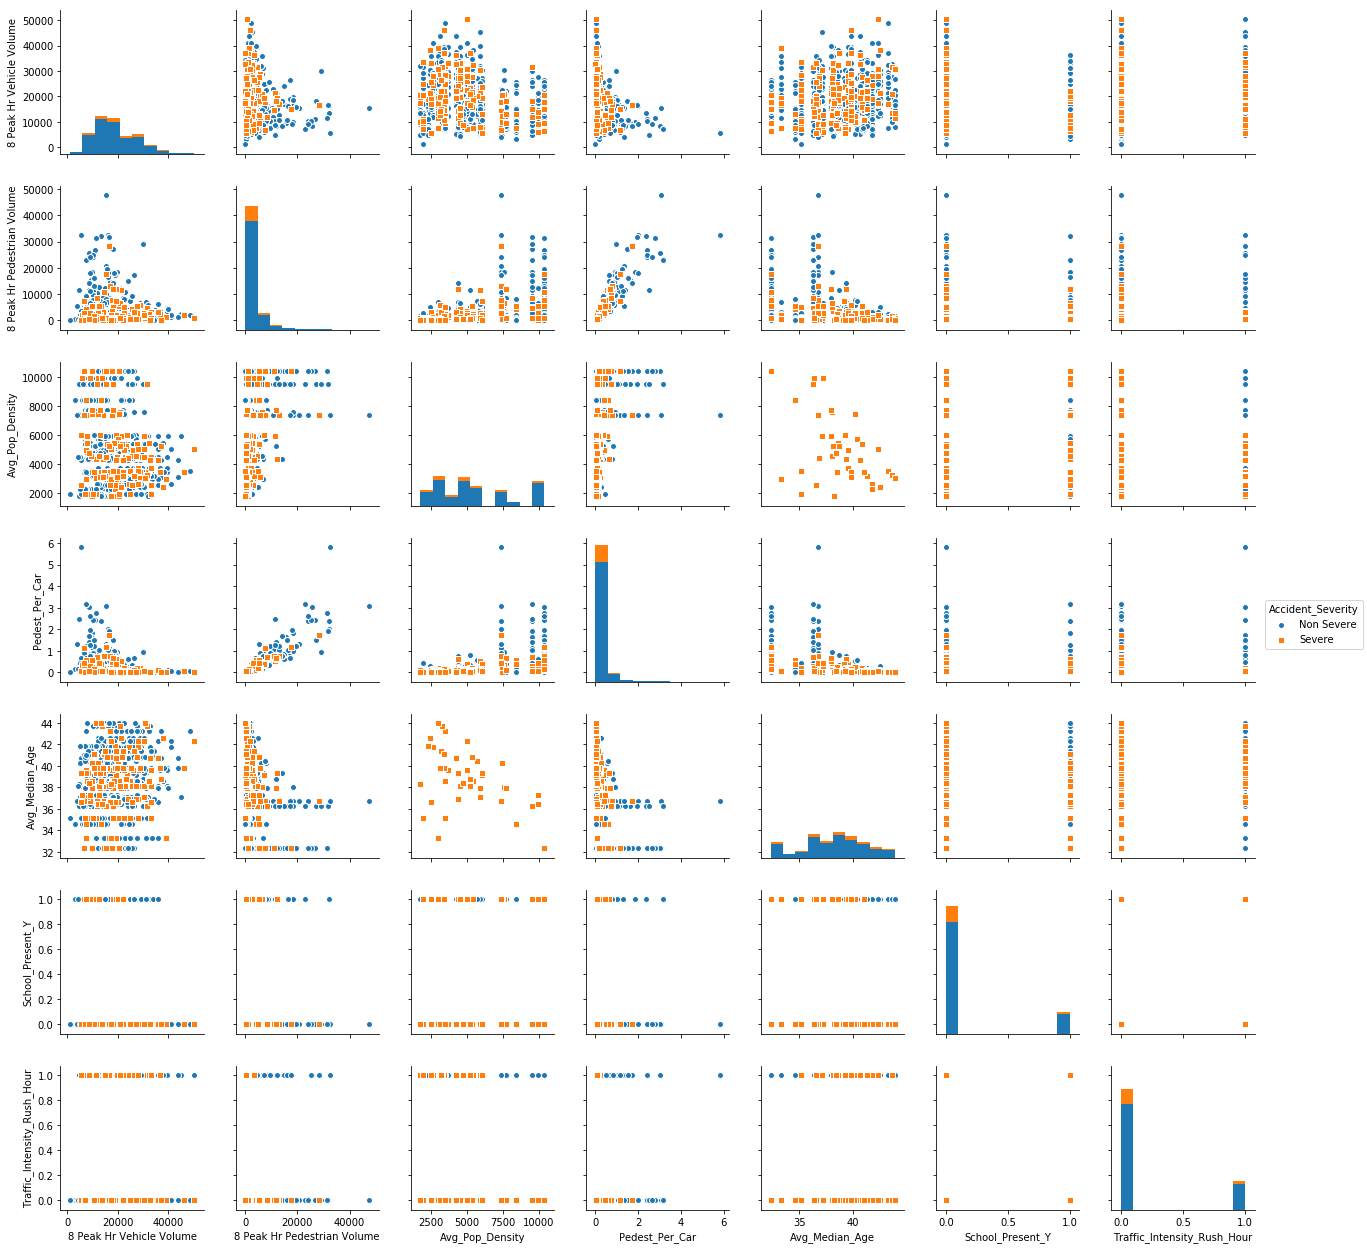

In [139]:
# These are variables related to population and volume of vehicles
columns=['8 Peak Hr Vehicle Volume','8 Peak Hr Pedestrian Volume', 'Avg_Pop_Density', 'Pedest_Per_Car','Avg_Median_Age','School_Present_Y','Traffic_Intensity_Rush_Hour','Accident_Severity']
sns.pairplot(df_explore_sev[columns],hue="Accident_Severity", markers=["o", "s"])

Most of the features are binary 1 or 0 , however, we can se that there are other variables that are related to volume of people and vehicles that spread out depending on the "severty".

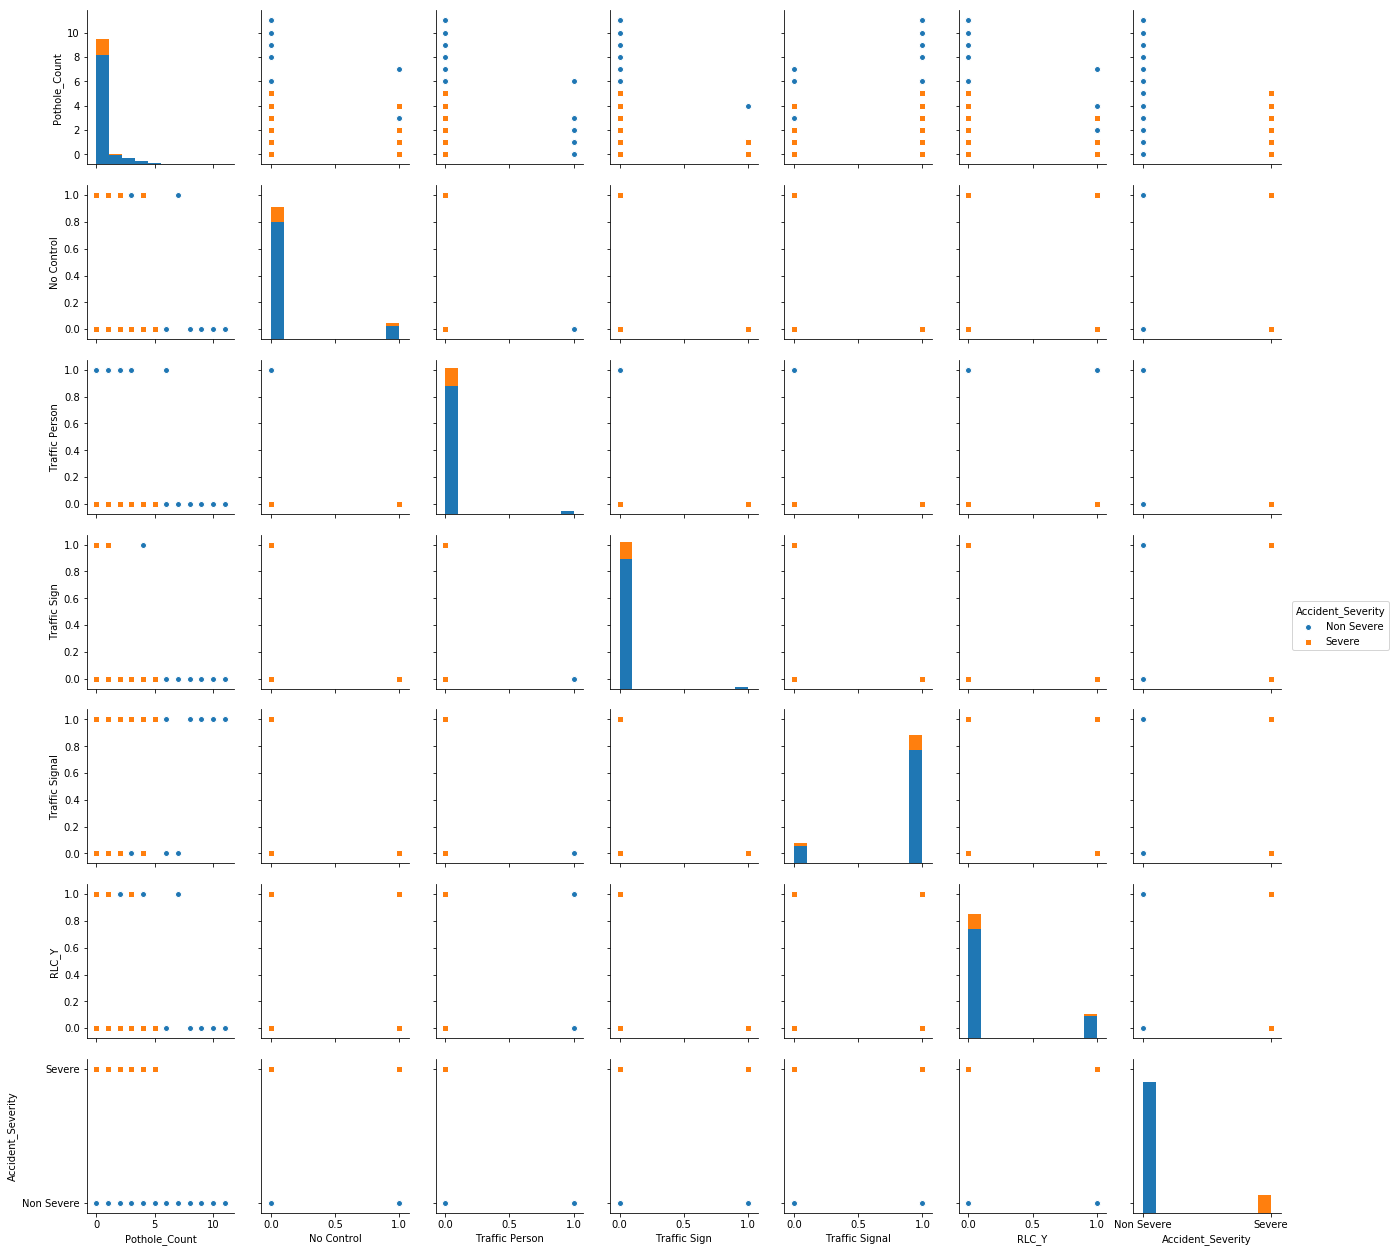

In [140]:
sns.pairplot(df_explore_sev, hue="Accident_Severity", markers=["o", "s"], vars=['Pothole_Count','No Control', 'Traffic Person', 'Traffic Sign','Traffic Signal','RLC_Y','Accident_Severity' ])

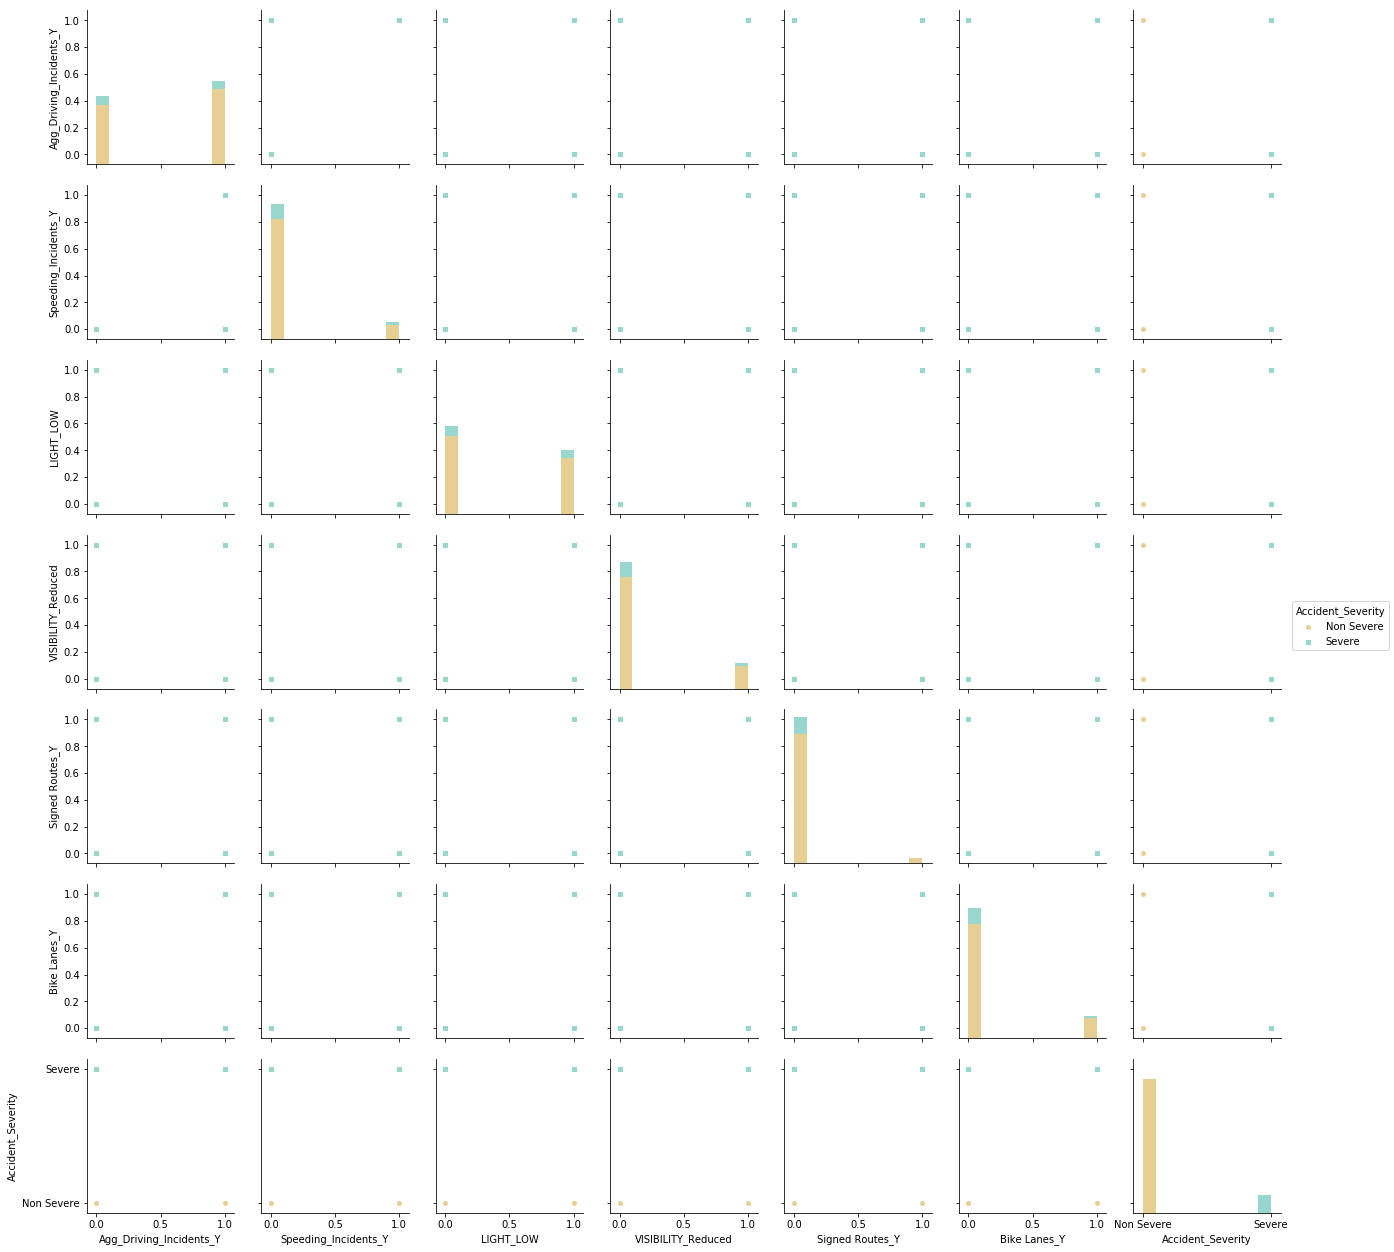

In [141]:
sns.pairplot(df_explore_sev, hue="Accident_Severity",palette='BrBG', markers=["o", "s"], vars=['Agg_Driving_Incidents_Y','Speeding_Incidents_Y', 'LIGHT_LOW', 'VISIBILITY_Reduced','Signed Routes_Y','Bike Lanes_Y','Accident_Severity' ])

The graphs above gave us a broad idea of the correlation of variables; however, it did not give a good insight of their importance to solve our classification problem. Therefore, a deeper analysis is required and it is shown in the folowing graphs.

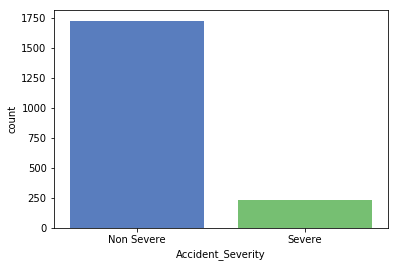

In [142]:
sns.countplot(x='Accident_Severity',data=df_explore_sev, palette="muted")

The number of fatal accidents in the last 10 years represent 12 % of the total. The approach is to decrease this percentage by the use of the below model to help in the decision of preventive and reactive actions.
The difference between non-severe and severe is very important for that reason we use class balancing on the training set below.

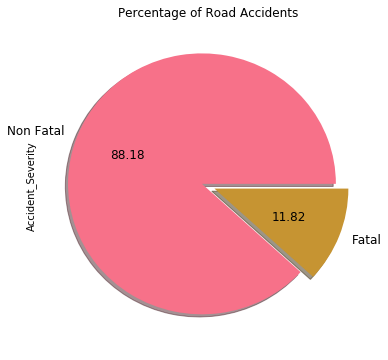

In [143]:
colors=sns.color_palette("husl",7)
pd.Series(df_explore_sev["Accident_Severity"]).value_counts().plot(kind="pie",colors=colors,
    labels=["Non Fatal", "Fatal"],explode=[0.05,0.05],
    shadow=True,autopct='%.2f', fontsize=12,figsize=(6, 6),title = "Percentage of Road Accidents")

In [144]:
#Function to create percent stacked bar charts
def stack_plot(x, y):
    df_local = df_explore_sev[[x, y]]
    df_local = df_local.groupby([x, y]).size().reset_index(name='Counts')
    df_local = df_local.pivot_table('Counts', [y], x, aggfunc='sum')
    df_local = df_local.div(df_local.sum(1), axis=0)

    plt.figure( figsize=(20,10) )
    df_local.plot(kind='bar', stacked=True)
    plt.xlabel(y)
    plt.ylabel('Percent of Class')
    plt.title('Percentage of Accidents for Each Class per Severity')
    plt.show()

In the case of fatal accidents (severe), aggressive driving is typically thought of as an important cause of the accident, as the following graph shows us. In the case of fatal accidents, half of them had aggressive driving as a cause for the accident. However, looking at the non-severe accidents, where a fatality did not occur, more are caused by aggressive accidents. This indicates aggressive driving may contribute to an accident being severe but there are other differentiating factors.

<Figure size 1440x720 with 0 Axes>

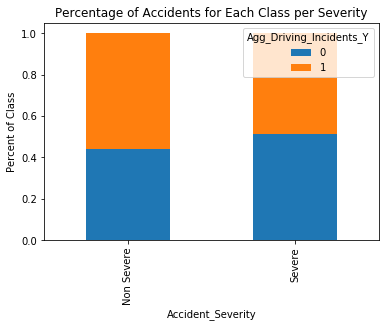

In [145]:
stack_plot('Agg_Driving_Incidents_Y', 'Accident_Severity')

A differentiating factor could be the road surface condition. This is shown in the plot below where road surface condition is snow (1= Yes) and plotted by accident severity. In this plot, a higher percentage of severe accidents, which caused a fatality, had snow covered roads compared to non severe accidents. 

<Figure size 1440x720 with 0 Axes>

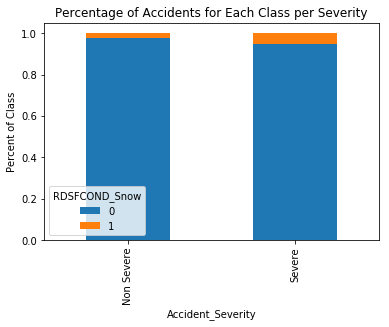

In [146]:
stack_plot('RDSFCOND_Snow', 'Accident_Severity')

Seasons such as winter, spring, summer, and fall are also factors that contribute to a fatal accident. If we compare the relationship between the number of fatal accidents and winter, the graph below shows that a higher percentage of severe (fatal) accidents happen in winter.

<Figure size 1440x720 with 0 Axes>

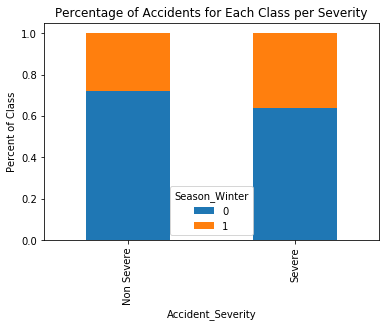

In [147]:
stack_plot('Season_Winter', 'Accident_Severity')

These percent bar graphs are meant to indicate that a multitude of factors influence the severity of accidents and a higher complexity model may be needed in order to evaluate the relationship. 

A graph with the importance of each feature will be presented in the folowing step after running the chosen model. However, this exploratory analysis shows that the data has many factors that influence the severity of accidents. 

Moreover, it is important to have a look at variables such as volume and population to have an better understanding of their distribution and how it could affect the model.

Text(0.5,1,'Number of accidents by intersection')

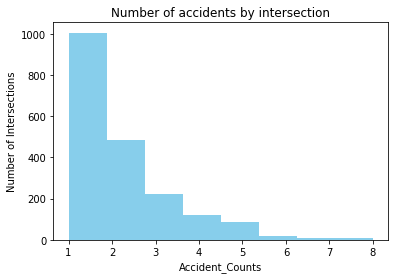

In [148]:
plt.hist(x='Accident_Counts',data=df_explore_sev,bins=8, color="skyblue")
plt.xlabel('Accident_Counts')
plt.ylabel('Number of Intersections')
plt.title('Number of accidents by intersection')

The majority of intersections in this datset have had at least 1 accident and at few intersections have had a maximum of 8 accidents. However, which ones will have severe accidents at them? The model will help us to solve this research question and allocate resources to the intersections with fatal accidents which is our target.

Text(0.5,1,'Volume of pedestrians by intersection')

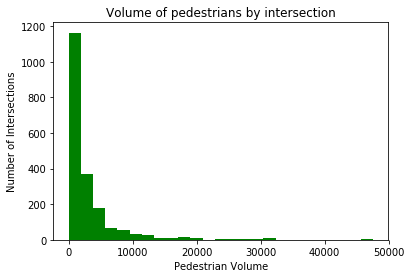

In [149]:
plt.hist(x='8 Peak Hr Pedestrian Volume',data=df_explore_sev,bins=25,color='green')
plt.xlabel('Pedestrian Volume')
plt.ylabel('Number of Intersections')
plt.title('Volume of pedestrians by intersection')

The volume of pedestrian by intersection present a distribution that concentrates the major number of pedestrians betweem 0 and 10000 pedestrains.

Text(0.5,1,'Volume of vehicles by intersection')

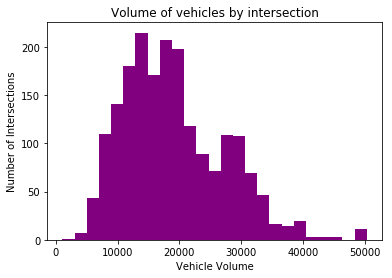

In [150]:
plt.hist(x='8 Peak Hr Vehicle Volume',data=df_explore_sev,bins=25, color= 'purple')
plt.xlabel('Vehicle Volume')
plt.ylabel('Number of Intersections')
plt.title('Volume of vehicles by intersection')

Regarding volume of vehicles by intersection, the graph represents a normal distribution with the volume concentrate at 20000 vehicles by intersection. 

Text(0.5,1,'Population Density by intersection')

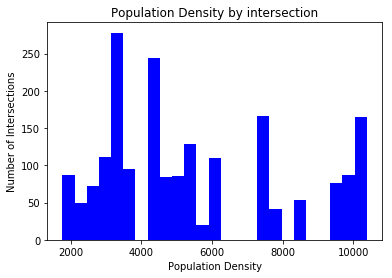

In [151]:
plt.hist(x='Avg_Pop_Density',data=df_explore_sev,bins=25, color = 'blue')
plt.xlabel('Population Density')
plt.ylabel('Number of Intersections')
plt.title('Population Density by intersection')

Text(0.5,1,'Median Age by intersection')

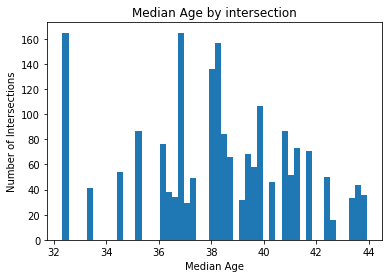

In [152]:
plt.hist(x='Avg_Median_Age',data=df_explore_sev,bins=50)
plt.xlabel('Median Age')
plt.ylabel('Number of Intersections')
plt.title('Median Age by intersection')

The median age could affect how safety consience individuals are for that region. E.g. a younger population could be more likely to not wear a seatbelt versus an older population (or vice versa).

Text(0.5,1,'Number of pothole by intersection')

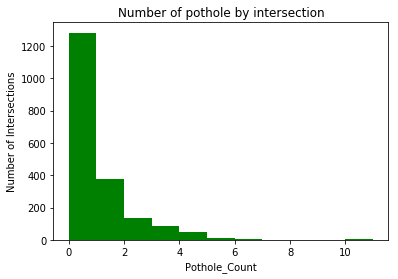

In [153]:
plt.hist(x='Pothole_Count',data=df_explore_sev,bins=11, color='green')
plt.xlabel('Pothole_Count')
plt.ylabel('Number of Intersections')
plt.title('Number of pothole by intersection')

Finally, the majority of potholes is between 0 and 2 potholes around an intersection with a maximum of 11 potholes

This exploratory analysis gives an idea of factors that may contribute towards accident severity and provides insight into our research question:

Where should resources be deployed to reduce fatalities by motor vehicles in urban centres?

Identifying intersections with the biggest number of fatal accidents and relating this locations with the posible causes can help policymakers as well as road users to take preventive and reactive actions.

# D. Model Implementation

For this project, there are two models: (1) a classification type model to classify if an accident were to occur with a given set of feature attributes would it be severe or non-severe. and (2) a regression type model to predict the number of accidents to occur at a given intersection with a set of feature attributes. The regression model is not used for the purposes of the report or presentation.

### Classification Model Implementation

For the classification type model, the classification is between a severe (fatal) or a non-severe accident occuring. As indicated in the report and in the overview description above, the City of Toronto currently places resources such as police, ambulance and fire within 12 minutes of all locations of the city. However, if this model classifies a particular accident that could occur as severe, city resources could be placed nearby in the form of a police patrolling for speeding or ambulance/fire to lower first aid response times. With this combination of prevention and reactive measures, city staff have the potential to stop severe accidents from occuring or at least minimize the impacts of them. 
The model implementation process involves: preparing the features, performing a train-test split, tuning the models hyperparameters for improved performance, and running the model on the test data set. Accuracy metrics, output plots and a discussion of the results are provided below. Comments are provided for the specific details on select code lines below. Other algorithms such as logistic regression, support vector machines, and XGBoost were tried, however the leading model was a RandomForest classifier. The chosen RandomForest model is chosen in the code below.

#### Prepare Model Features and Target

In [154]:
#Drop text data for columns
df_model_columns = df_model.drop(columns=['Main', 'Side 1 Route', 'Accident_Severity'])

In [155]:
# Labels are the values we want to predict
df_model_label = np.array(df_model['Accident_Severity'])
#Drop coulmns depending on target population (i.e. cyclist or pedestrian)

df_model_features = df_model.drop(columns=['Accident_Severity'], axis = 1)

# Convert to numpy array
features = np.array(df_model_features)

In [156]:
#Perform train-test split for features and target
train_features, test_features, train_labels, test_labels = train_test_split(features, df_model_label, test_size = 0.2, random_state = 12)

In [157]:
#Obtain Main and Side 1 Route for Data
train_features_fil = train_features[:, 2:]
test_features_fil = test_features[:, 2:]
test_str_data = test_features[:, :2]

In [158]:
#Class balancing on training set
sm = SMOTE(random_state=12, ratio=1.0)
train_features_res, train_labels_res = sm.fit_sample(train_features_fil, train_labels)

C:\Users\Skynet\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


#### Random Forest - Classifier

In [159]:
best_param = {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 800, 'bootstrap': False}

•	Depth of the tree: number of splits the tree does to capture more information on data
•	Max Features: limit for number of features in each tree
•	Minimum samples per leaf node: Specifies how many samples must be in the training data to create a node
•	Number of splits per node: Specifies how many times the variable is randomly split at each node
•	Number of estimators: Specifies how many times the model re-samples the data and builds an individual tree 

In [160]:
#Initialize the RandomForestClassifier
rf_class = RandomForestClassifier(random_state = 12)
rf_class.set_params(**best_param)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=30, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=None,
            oob_score=False, random_state=12, verbose=0, warm_start=False)

In [161]:
#Hyperparameters:
# Create the random grid to narrow down hyperparameter range
#param_grid = {'bootstrap': [True, False], 'max_depth': [5, 8, 10, 20, 30, 40], 'max_features': ['auto', 'sqrt'], 'min_samples_leaf': [1, 2, 4, 5, 6, 8, 9], 'min_samples_split': [2, 3, 4, 5, 6, 7,8, 9, 12], 'n_estimators': [200,300, 400,500, 600, 700, 800]}
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
#rf_rand = RandomizedSearchCV(estimator = rf_class, param_distributions = param_grid, n_iter = 50, cv = 5, verbose=2, random_state=42, n_jobs = -1)

In [162]:
#Hyperparameter tuning with Grid Search to find best parameters (currently commented out)
#param_grid = {'bootstrap': [True, False], 'max_depth': [25, 30, 35], 'max_features': ['auto', 'sqrt'], 'min_samples_leaf': [1, 2, 3], 'min_samples_split': [5, 6, 7], 'n_estimators': [700, 800, 900]}
# Grid search of parameters, using 3 fold cross validation, 
# Scoring for average precision but this can be changed depending on model
#rf_rand = GridSearchCV(estimator = rf_class, param_grid = param_grid, cv = 5, verbose=2, n_jobs = -1)

In [163]:
#Fit RandomForestClassifier with best hyperparameters model
rf_class.fit(train_features_res, train_labels_res)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=30, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=None,
            oob_score=False, random_state=12, verbose=0, warm_start=False)

In [164]:
#rf_rand.best_params_

In [165]:
#Get predictions based on decision threshold as well as normalized sum of individual tree predictions
rf_predictions = rf_class.predict(test_features_fil)
rf_predictions_scores = rf_class.predict_proba(test_features_fil)

##### Random Forest Classification - Accuracy Metrics and Plots

In [166]:
print(" ")
print("Classification report based on test data===============================")
print(classification_report(test_labels, rf_predictions))

 
Classification report based on test data===============================
              precision    recall  f1-score   support

  Non Severe       0.92      0.99      0.96       347
      Severe       0.88      0.34      0.49        44

   micro avg       0.92      0.92      0.92       391
   macro avg       0.90      0.67      0.72       391
weighted avg       0.92      0.92      0.90       391



In [167]:
#Get RandomForestClassifier feature importances and join with the feature names
 
feature_importances = pd.DataFrame(rf_class.feature_importances_,
                                   index = df_model_columns.columns,
                                    columns=['Feature_Importance']).sort_values('Feature_Importance',  ascending=False)

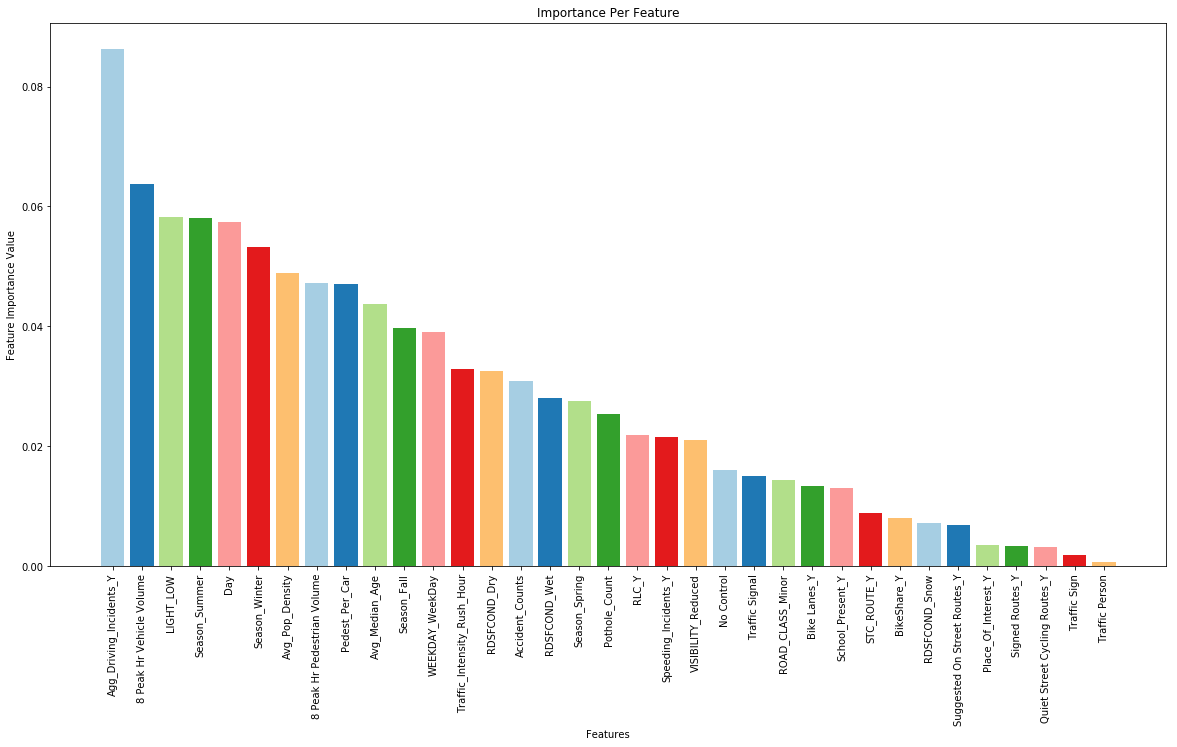

In [168]:
#Plot feature importnance scores 
colors=sns.color_palette("Paired", 7)
plt.figure( figsize=(20,10) )
plt.bar(feature_importances.index,feature_importances['Feature_Importance'],color=colors)
plt.xticks(rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Feature Importance Value')
plt.title('Importance Per Feature')
plt.show()

In [169]:
#Use sklearn function to get the TPR and FPR for Severe accidents for each decision threshold
false_positive_rate, true_positive_rate, thresholds = roc_curve(test_labels, rf_predictions_scores[:,1], pos_label='Severe')
roc_auc = auc(false_positive_rate, true_positive_rate)

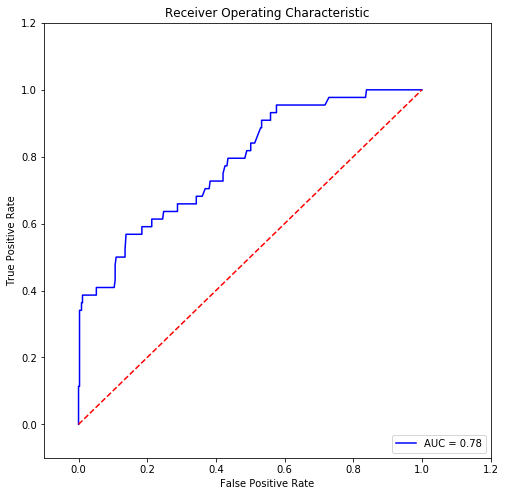

In [170]:
#Plot the ROC curve to see the change in TPR vs. FPR for different decision thresholds. (sklearn code)
#Note: the curve is above the line of random chance
plt.figure(figsize=(8,8))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

The above ROC curve is useful for visualizing the tradeoff for TPR and FPR. The area under the curve (AUC) value is shown in the bottom right, with a value of 0.78. As this is well above 0.5, the model performs better than a random predictor. It also can be useful for selecting a decision threshold. In this model one of the graphs below will be used for that as it's easier to visualize the precision-recall tradeoff. 

In [171]:
#Use sklearn's library to get the precision and recall for each decision threshold
p, r, thresholds = precision_recall_curve(test_labels, rf_predictions_scores[:,1], pos_label='Severe')

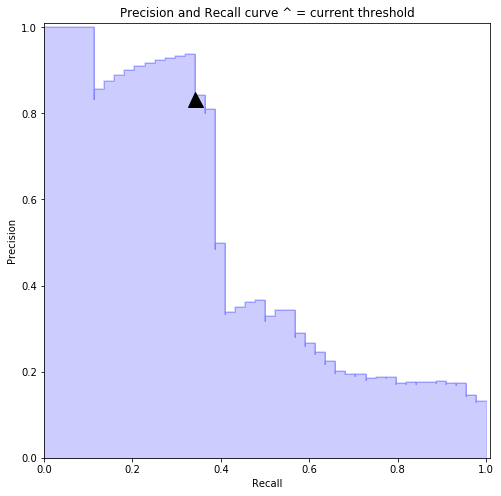

In [172]:
#Plot precision vs. recall tradeoff for each decision threshold (sklearn code)
plt.figure(figsize=(8,8))
plt.title("Precision and Recall curve ^ = current threshold")
plt.step(r, p, color='b', alpha=0.2,
             where='post')
plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
plt.ylim([0.0, 1.01]);
plt.xlim([0.0, 1.01]);
plt.xlabel('Recall');
plt.ylabel('Precision');
    
# plot the current threshold on the line
close_default_clf = np.argmin(np.abs(thresholds - 0.5))
plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)
plt.show()

As shown in the figure above, the model has high precision for approximately 40% of the severe accident incidents. However, as it attempts to increase the recall and find all relevant instances of severe accidents, its precision goes down substanially. A theory for this result is that some causes are beyond what can be modelled by the given data. These are factors such as make of car and corresponding safety features that will greatly affect if an accident causes a fatality or not. The model then provides good precision for accidents whose severity does depend on the features available. 

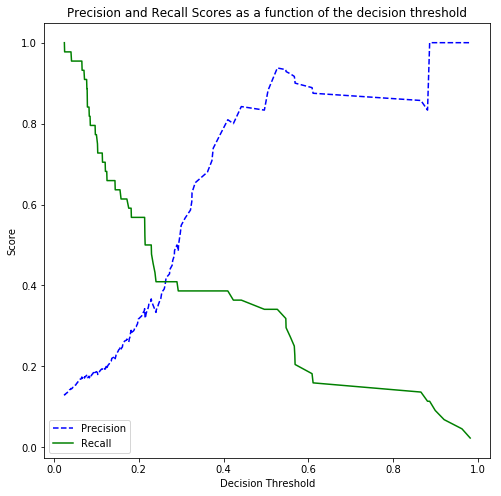

In [173]:
#Plot precision and recall as a function of decision thresholds to see tradeoff (sklearn code) - Use to select decision thresold
plt.figure(figsize=(8, 8))
plt.title("Precision and Recall Scores as a function of the decision threshold")
plt.plot(thresholds, p[:-1], "b--", label="Precision")
plt.plot(thresholds, r[:-1], "g-", label="Recall")
plt.ylabel("Score")
plt.xlabel("Decision Threshold")
plt.legend(loc='best')
plt.show()

##### Extracting Data for Tableau Dashboard

In [174]:
tab_data = street_data.drop(columns = ['TCS #', 'Midblock Route', 'Side 2 Route', 'Activation Date', 'Count Date', '8 Peak Hr Vehicle Volume', '8 Peak Hr Pedestrian Volume'])
tab_data = tab_data.drop_duplicates(subset=['Main', 'Side 1 Route'])

In [175]:

df_str_test = pd.DataFrame(test_str_data, columns=['Main', 'Side 1 Route'])
df_pred = pd.DataFrame(rf_predictions, columns=['Predicted_ACC_SEV'])
df_actual = pd.DataFrame(test_labels, columns=['Actual_ACC_SEV'])
df_features_out = pd.DataFrame(test_features_fil, columns = df_model_columns.columns)
temp_pred_act = pd.concat([df_str_test,df_features_out, df_pred, df_actual], axis=1)

In [176]:
tab_data_out = pd.merge(temp_pred_act, tab_data, how='left', on=['Main', 'Side 1 Route'])

In [177]:
#Output results with intersections and LAT/LON's to plot of Tableau dashboard (Commented Out)
#writer = pd.ExcelWriter('Output\output.xlsx')
#tab_data_out.to_excel(writer,'Sheet1')
#writer.save()

##### Testing to see how controllable features affect model

In [178]:
#Create data frame for test features
feature_analysis_class = pd.DataFrame(test_features, columns=df_model_features.columns)

In [179]:
#Concat. together the predicted and actual severity
df_pred = pd.DataFrame(rf_predictions, columns=['Predicted_ACC_SEV'])
df_actual = pd.DataFrame(test_labels, columns=['Actual_ACC_SEV'])
temp_pred_act = pd.concat([df_pred, df_actual], axis=1)

In [180]:
#Concat. with features 
feature_analysis_class = pd.concat([feature_analysis_class, temp_pred_act], axis=1)

In [181]:
#Filter data for precise predictions of severe accidents
feature_analysis_class = feature_analysis_class.loc[(feature_analysis_class['Predicted_ACC_SEV'] == 'Severe') & (feature_analysis_class['Actual_ACC_SEV'] == 'Severe')]

In [182]:
#Add a traffic signal at the intersection
feature_analysis_class['No Control'] = '0'
feature_analysis_class['Traffic Person'] = '0'
feature_analysis_class['Traffic Sign'] = '0'
feature_analysis_class['Traffic Signal'] = '1'
#Add a streetlight at the intersection
feature_analysis_class['LIGHT_LOW'] = '1'
#Salt roads at the intersection (for winter only)
feature_analysis_class['RDSFCOND_Wet'] = '0'
feature_analysis_class['RDSFCOND_Snow']= '0'
feature_analysis_class['RDSFCOND_Dry'] = '1'
#Set up patrols for aggressive driving and speeding
feature_analysis_class['Agg_Driving_Incidents_Y'] = '0'
feature_analysis_class['Speeding_Incidents_Y'] = '0'
#Fix potholes in and around the intersection
feature_analysis_class['Pothole_Count'] = '0'

In [183]:
#Drop unecessary columns
feature_analysis_class = feature_analysis_class.drop(columns=['Main', 'Side 1 Route', 'Predicted_ACC_SEV', 'Actual_ACC_SEV'])

In [184]:
#Convert to array for model
features_analysis_pred = np.array(feature_analysis_class)

In [185]:
#Predict accident severity with random forest model
features_analysis_pred_results = rf_class.predict(features_analysis_pred)

This method was used to determine how altering these features would affect the model as the Random Forest classifier is a black box. By altering these controllable features, it shows that the intersection can be improved through preventative safety measures in most cases (14 out of 15)

In [186]:
#Print out results (14 out of 15 results were re-classified as non-severe where no fatality will occur)
features_analysis_pred_results

array(['Severe', 'Non Severe', 'Non Severe', 'Non Severe', 'Non Severe',
       'Non Severe', 'Non Severe', 'Non Severe', 'Non Severe',
       'Non Severe', 'Non Severe', 'Non Severe', 'Non Severe',
       'Non Severe', 'Non Severe'], dtype=object)

##### Classification Outputs

As a baseline for the current model, city resources are placed to have a 12 minute response time to any region of the city. This indicates that the city is using random chance that an accident will occur and whether or not it will be severe as to require city resources respond. Therefore, to be of any value, our model has to have a better precision than 0.5. 
As shown in the classification report above, Severe accidents (i.e. fatal) can be predicted with a precision of 0.88 and a recall of 0.34. For this model, the main area of focus is to minimize the number of false positives (i.e. increase precision). The primary goal of the model is to predict severe accidents so that additional resources can be placed in close proximity to these intersections. Although an aim is to minimze the number of false negatives, it is not the primary goal of the model. Additionally, false negatives will still be covered by city resources as it is not recommended to change the overall 10 minute response time.

The most important features of the model are the aggressive driving incidents, vehicle volumes, lighting/daytime, and seasonality. Other features such as if the intersection has places of interest or traffic signs are less important to the model but still are a factor in the model decisions. A plot of feature importance is shown above. A recommendation for this model would be to have access to live dynamic model features such as traffic and weather. This recommendation would be key if the model was to be used in production and run on a regular basis. As well some features are controllable and others are not. The main controllable features are: (Traffic Signal, Traffic Sign, Traffic Person, No Control), (Agg_Driving_Incidents_Y, Speeding_Incidents_Y), Pothole_Count, LIGHT_LOW, and RDSCOND. As shown in the sub-section "Testing to see how Features affect model" above, altering these to improve the intersections safety leads to the model re-classifying these as Non-Severe (i.e. a fatality will not occur). This shows by implementing preventative controls does make the intersection less prone to having a fatal accident. These controls will be further discussed in the report.

In this model, the precision vs. recall tradeoff is very important. As stated above for false negatives, Severe accidents classified as Non-Severe, will still be covered by the cities existing 12 minute response time policy. However, minimizing the false positives is key to providing a model with value as the intention is to target areas with a Severe accident with preventative and reactive measures. To minimze false positives, the precision for Severe accidents can be increased by adjusting the decision threshold, which is currently at 0.5 as shown in the "Precision and Recall Scores as a function of the decision threshold" figure above. However, increasing the decision threshold reduces the recall of the model. Two plots that show this relationship precision-recall trade off are shown above. The current decision threshold of 0.5 will be kept as it provides a high precision score while still capturing enough of all severe instances to provide users with enough  severe accident locations to focus on.

A final discussion point is the limitations of the model. Certain features that signficantly affect severity of crashes cannot be determined by publicly available data. These include whether seat belts are being worn, model/make of vehicles per intersection and other vehicle safety measures. Although demographic features such as age can be used as proxies for "responsbility" and therefore seatbelts in use, it is a stretch and not granular enough since it's at the city ward level. Therefore, unless this data can be collected, there will always be a limitation for the degree of accuracy that the model can achieve.  

### Regression - Model Implementation (Not Used For Report or Presentation)

The regression type model for this project is predicting the number of accidents to occur on a given intsersection. The City of Toronto currently has a number of metrics and intiatives for improving the safety of city streets. However, no publicly available information has been provided on if a machine learning prediction is being done. With this model and its predictions, city staff can isolate accidents with higher accident counts and review the features that are the cause. City staff can recommend prevention measures to improve the safety of city streets and reduce accident risk.
The model implementation process involves: preparing the features (e.g. scaling), performing a train-test split, tuning the models hyperparameters for improved performance, and running the model on the test data set. Accuracy metrics, output plots and a discussion of the results are provided below. Comments are provide for the specific details on select code lines below. 

In [187]:
df_regress_model = df_regress_model.drop(columns=['Main', 'Side 1 Route'])

In [188]:
# Labels are the values we want to predict
df_regress_model_label = np.array(df_regress_model['Accident_Counts'])
#Drop coulmns depending on target population (i.e. cyclist or pedestrian)

df_regress_model_features = df_regress_model.drop(columns=['Accident_Counts'], axis = 1)

# Convert to numpy array
features_regress = np.array(df_regress_model_features)

In [189]:
#Perform train-test split for features and target
train_features_regress, test_features_regress, train_labels_regress, test_labels_regress = train_test_split(features_regress, df_regress_model_label, test_size = 0.8, random_state = 42)

In [190]:
# Scale train and test sets separately to avoid giving information to test set
scaler_std = preprocessing.StandardScaler()
train_features_regress_scaled = scaler_std.fit_transform(train_features_regress)
test_features_regress_scaled = scaler_std.transform(test_features_regress)

#### Lasso Regression

In [191]:
#Use LassoCV to hyparameter tuned the Lasso regression model
reg =LassoCV(cv=5, random_state=0).fit(train_features_regress_scaled, train_labels_regress)

In [192]:
print(" ")
print("R^2 score for training data===============================")
reg.score(train_features_regress_scaled, train_labels_regress)

 
R^2 score for training data===============================


0.16931783361978536

##### Lasso Regression  - Accuracy Metrics and Plots

In [193]:
LassoRegCV_LR_MSE = mean_squared_error(reg.predict(test_features_regress_scaled), test_labels_regress)
LassoRegCV_LR_r2_score = r2_score(reg.predict(test_features_regress_scaled), test_labels_regress)
LassoRegCV_LR_MAE = mean_absolute_error(reg.predict(test_features_regress_scaled), test_labels_regress)
LassoRegCV_LR_RMSE = np.sqrt(LassoRegCV_LR_MSE)

print(" ")
print("Verify error metrics on testing set data===============================")
print("R-Squared value for fit: ", LassoRegCV_LR_r2_score)
print("Mean Absolute Error: ", LassoRegCV_LR_MAE)
print("Mean Squared Error: ", LassoRegCV_LR_MSE)
print("Root Mean Squared Error: ", LassoRegCV_LR_RMSE)

 
Verify error metrics on testing set data===============================
R-Squared value for fit:  -3.788930214137033
Mean Absolute Error:  0.635731866875526
Mean Squared Error:  0.7215051119300758
Root Mean Squared Error:  0.8494145701187824


In [194]:
#Get feature names and coefficients from Ridge regression model
coeff_regress_lasso = pd.DataFrame(list(df_regress_model_features.columns.values),list(reg.coef_), columns=['Coefficients']).reset_index()
coeff_regress_lasso = coeff_regress_lasso.rename(index=str, columns={"index": "Weights"}).sort_values('Weights',  ascending=True).reset_index()

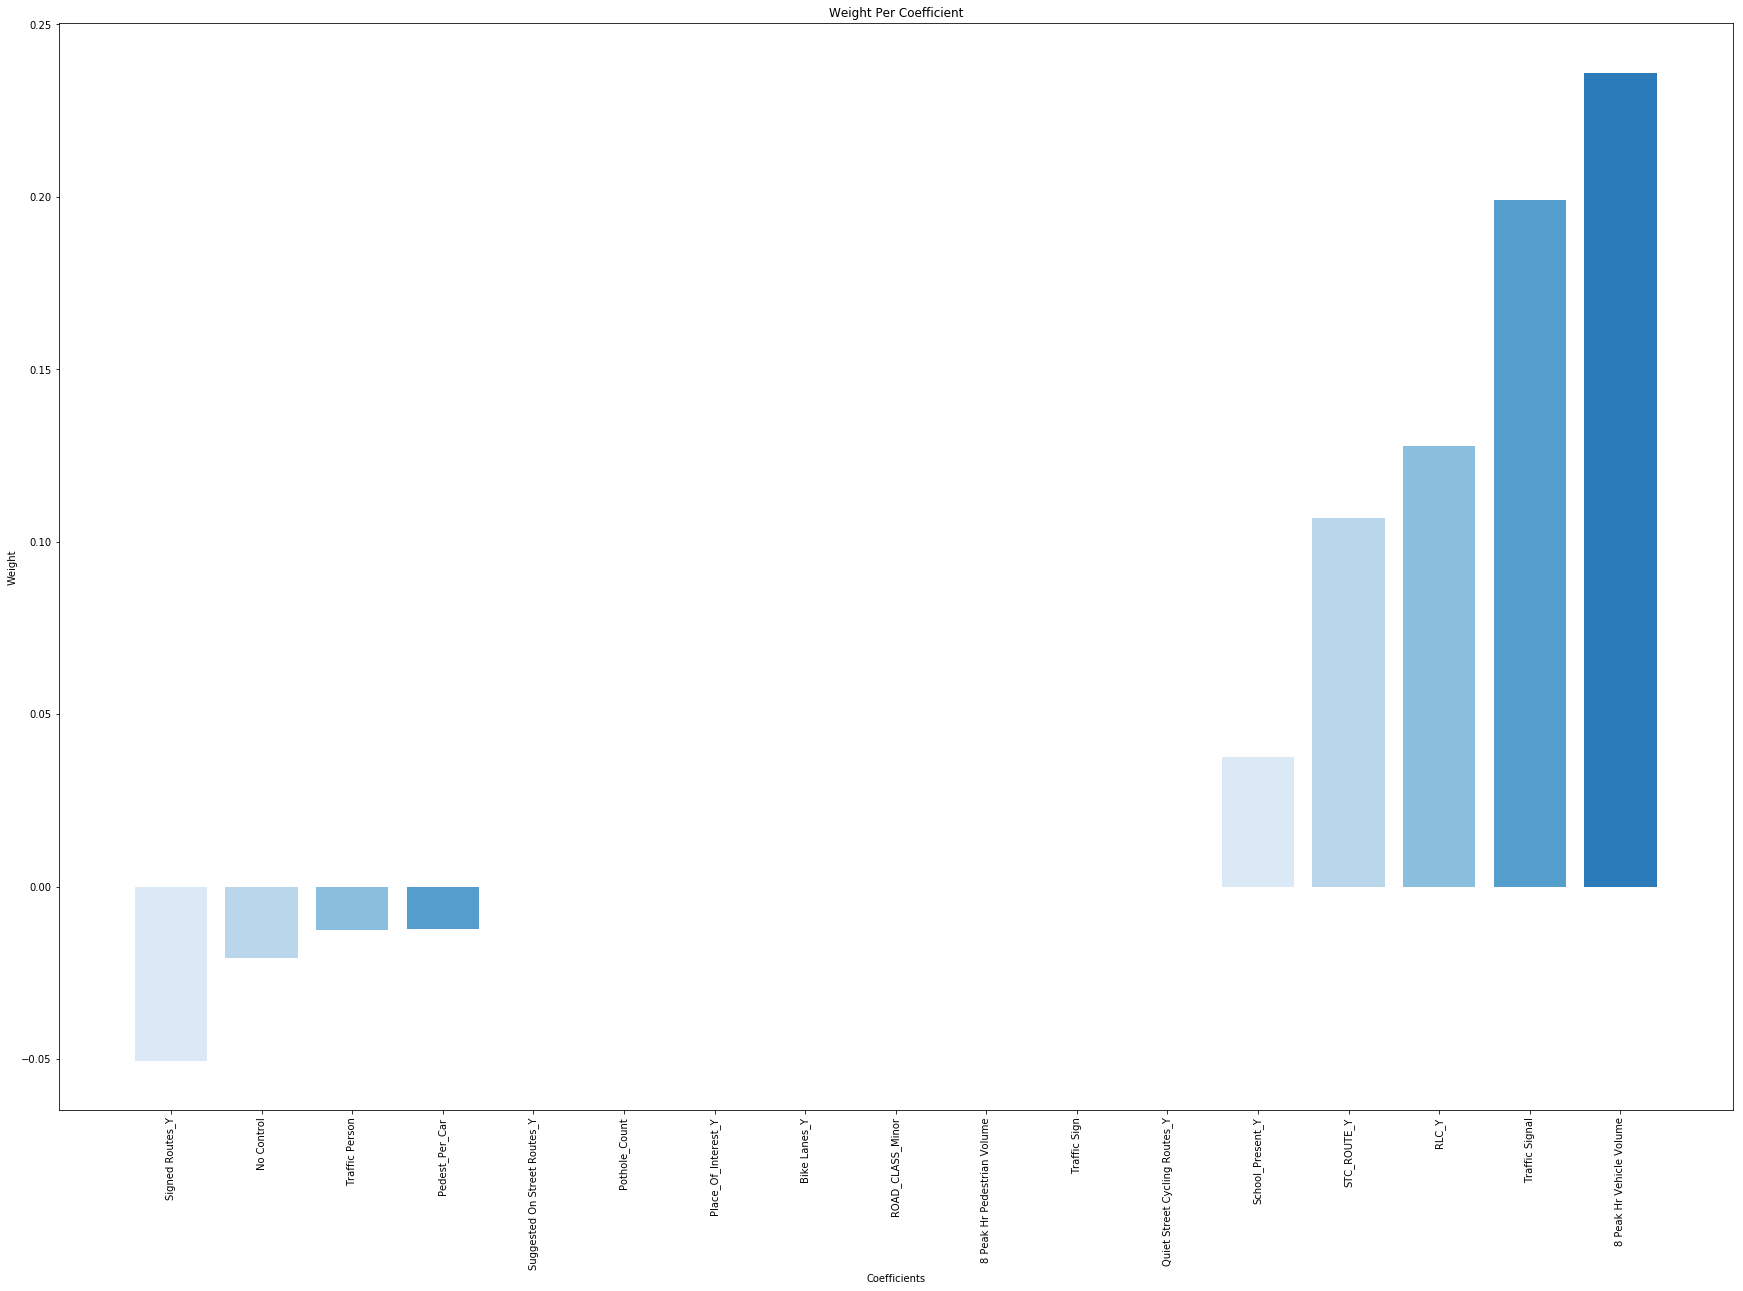

In [195]:
#Plot Ridge regression features and weights in ascending order
colors=sns.color_palette('Blues')
plt.figure( figsize=(30,20) )
plt.bar(coeff_regress_lasso['Coefficients'], coeff_regress_lasso['Weights'], color=colors)
plt.xticks(rotation='vertical')
plt.xlabel('Coefficients')
plt.ylabel('Weight')
plt.title('Weight Per Coefficient')
plt.show()

#### Ridge Regression

In [196]:
#Use RidgeCV to hyparameter tuned the Lasso regression model
ridge =RidgeCV(alphas=[1e-6, 1e-5, 1e-4, 1e-3, 1e-2],cv=5).fit(train_features_regress_scaled, train_labels_regress)

In [197]:
print(" ")
print("R^2 score for training data===============================")
ridge.score(train_features_regress_scaled, train_labels_regress)

 
R^2 score for training data===============================


0.1801067014059381

##### Ridge Regression - Accuracy Metrics and Plots

In [198]:
ridgeRegCV_LR_MSE = mean_squared_error(ridge.predict(test_features_regress_scaled), test_labels_regress)
ridgeRegCV_LR_r2_score = r2_score(ridge.predict(test_features_regress_scaled), test_labels_regress)
ridgeRegCV_LR_MAE = mean_absolute_error(ridge.predict(test_features_regress_scaled), test_labels_regress)
ridgeRegCV_LR_RMSE = np.sqrt(ridgeRegCV_LR_MSE)

print(" ")
print("Verify error metrics on testing set data===============================")
print("R-Squared value for fit: ", ridgeRegCV_LR_r2_score)
print("Mean Absolute Error: ", ridgeRegCV_LR_MAE)
print("Mean Squared Error: ", ridgeRegCV_LR_MSE)
print("Root Mean Squared Error: ", ridgeRegCV_LR_RMSE)

 
Verify error metrics on testing set data===============================
R-Squared value for fit:  -2.3251689276698078
Mean Absolute Error:  0.653311594552563
Mean Squared Error:  0.7537861463826458
Root Mean Squared Error:  0.8682085846054771


In [199]:
df_regress_model['Accident_Counts'].describe()

count    1076.000000
mean        1.500929
std         0.916515
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         8.000000
Name: Accident_Counts, dtype: float64

In [200]:
#Get feature names and coefficients from Ridge regression model
coeff_regress = pd.DataFrame(list(df_regress_model_features.columns.values),list(ridge.coef_), columns=['Coefficients']).reset_index()
coeff_regress= coeff_regress.rename(index=str, columns={"index": "Weights"}).sort_values('Weights',  ascending=True).reset_index()

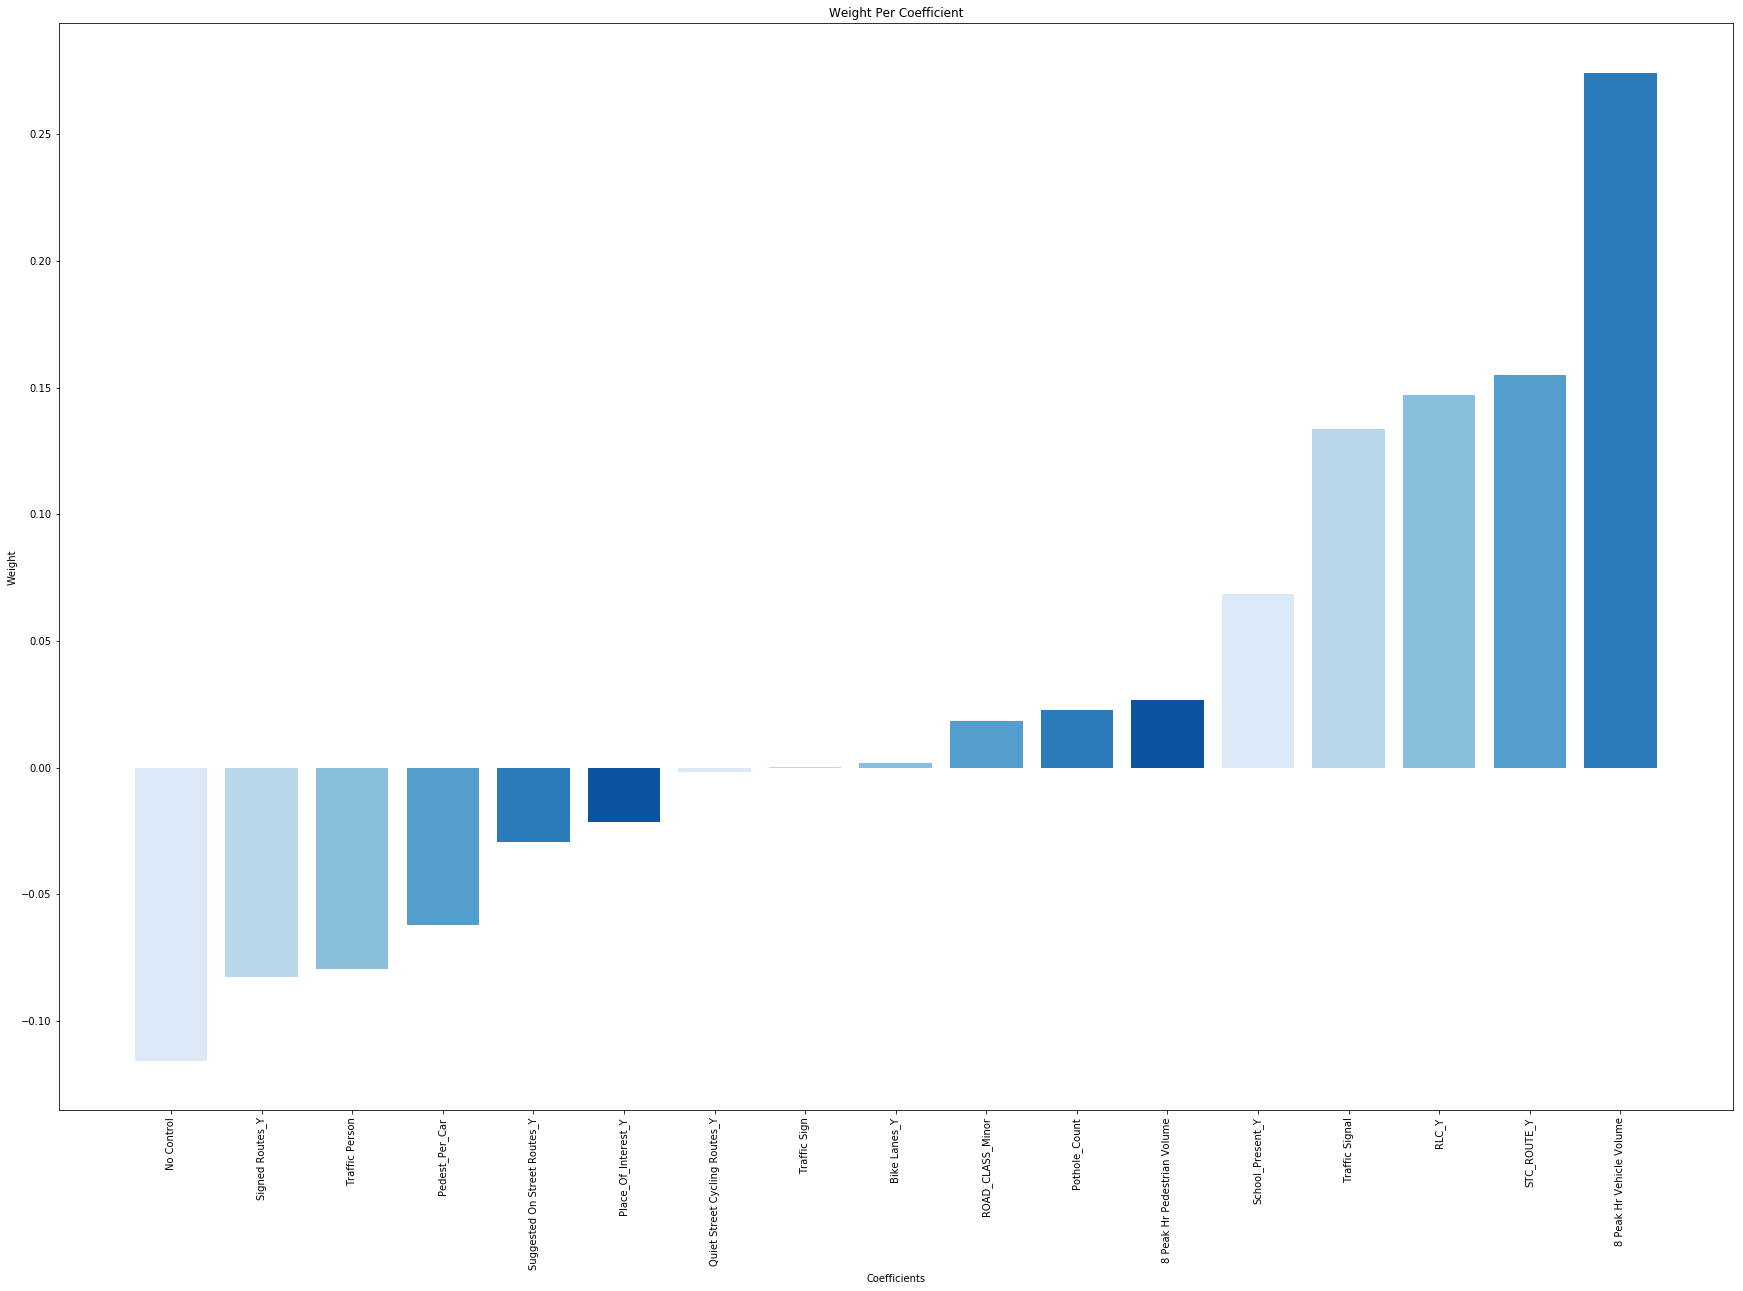

In [201]:
#Plot Ridge regression features and weights in ascending order
plt.figure( figsize=(30,20) )
plt.bar(coeff_regress['Coefficients'], coeff_regress['Weights'], color=colors)
plt.xticks(rotation='vertical')
plt.xlabel('Coefficients')
plt.ylabel('Weight')
plt.title('Weight Per Coefficient')
plt.show()

#### RandomForest Regression

In [202]:
#Initialize RandomForestRegressor 
rf_regress = RandomForestRegressor(n_estimators = 250, random_state = 42)

In [203]:
#Hyperparameters:
# Create the random grid
param_grid = {'bootstrap': [True, False],
 'max_depth': [5, 8, 10, 20, 30],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4, 5, 6, 8, 9],
 'min_samples_split': [2, 3, 4, 5, 6, 7,8, 9, 12],
 'n_estimators': [200, 400, 600]}
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_regress_rand = RandomizedSearchCV(estimator = rf_regress, param_distributions = param_grid, 
                          n_iter = 50, cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [204]:
#Training RandomForestRegressor, iterating over the hyperparameters to select best tuning
rf_regress_rand.fit(train_features_regress_scaled, train_labels_regress)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   56.8s finished
C:\Users\Skynet\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=50, n_jobs=-1,
          param_distributions={'bootstrap': [True, False], 'max_depth': [5, 8, 10, 20, 30], 'max_features': ['auto', 'sqrt'], 'min_samples_leaf': [1, 2, 4, 5, 6, 8, 9], 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 12], 'n_estimators': [200, 400, 600]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [205]:
rf_regress_rand.best_params_

{'bootstrap': False,
 'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 400}

##### Random Forest Regressor - Accuracy Metrics and Plots

In [206]:
RFRegCV_LR_MSE = mean_squared_error(rf_regress_rand.predict(test_features_regress_scaled), test_labels_regress)
RFRegCV_LR_r2_score = r2_score(rf_regress_rand.predict(test_features_regress_scaled), test_labels_regress)
RFRegCV_LR_MAE = mean_absolute_error(rf_regress_rand.predict(test_features_regress_scaled), test_labels_regress)
RFRegCV_LR_RMSE = np.sqrt(RFRegCV_LR_MSE)

print(" ")
print("Verify error metrics on testing set data===============================")
print("R-Squared value for fit: ", RFRegCV_LR_r2_score)
print("Mean Absolute Error: ", RFRegCV_LR_MAE)
print("Mean Squared Error: ", RFRegCV_LR_MSE)
print("Root Mean Squared Error: ", RFRegCV_LR_RMSE)

 
Verify error metrics on testing set data===============================
R-Squared value for fit:  -4.219980994870146
Mean Absolute Error:  0.6368140208752534
Mean Squared Error:  0.7416561798022671
Root Mean Squared Error:  0.8611946236491883


In [207]:
#Get RandomForestRegressor feature importances and join with the feature names
regress_feature_importances = pd.DataFrame(rf_regress_rand.best_estimator_.feature_importances_, index = df_regress_model_features.columns,
                                    columns=['Feature_Importance']).sort_values('Feature_Importance',  ascending=False)

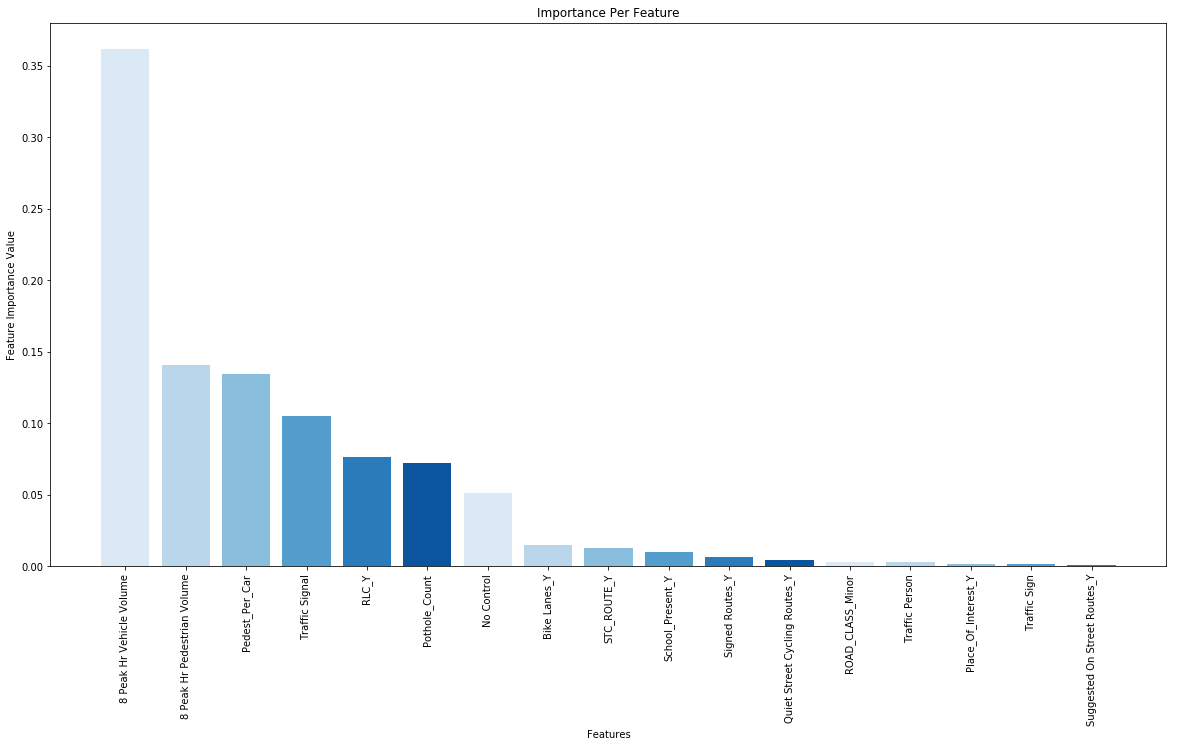

In [208]:
#Plot feature importnance scores 
plt.figure( figsize=(20,10) )
plt.bar(regress_feature_importances.index,regress_feature_importances['Feature_Importance'],  color=colors)
plt.xticks(rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Feature Importance Value')
plt.title('Importance Per Feature')
plt.show()

##### Regression Outputs

For the regression model, three different types of algorithms were attempted to predict the number of accidents at intersections. These algorithms were: 1) Lasso Regression , 2) Ridge Regression, and 3) Random Forest Regression. All the models had similar MSE, MAE, RMSE and R^2 values. The results, specifically the R^2 score, indicate that the regression models perform very poorly and do not explain the variance of the data very well. Even when using the feature selection properties of the Lasso model, the outcome was still a poor model. Based on these results, a more complex model and/or additional features/data will be needed to improve the performance. 

Plots shown above for the regression models are to show the feature weights or importance levels for each model. Information can be extracted from these plots to show how the model is affected by the different features. 

# E. Discussion

The classification model for accident severity will be briefly discussed below. As mentioned at the beginning of the notebook, the prediction of accident counts is not being included in the report or presentation. More specific details on that model and the performance can be found in the individual model sections.

As discussed at the beginning of the report, the intention was to answer the following question: __where should resources be deployed to reduce fatalities by motor vehicles in urban centres?__ To answer this, data was gathered, prepared, and finally modelled using a classification algorithm. The goal for this classification algorithm, which was chosen to be a Random Forest classifier, was to classify accidents that could occur as Severe (fatal) or Non-severe (non fatal) depending on feature attributes. The attributes for the model are a mixture of static (e.g. traffic control) and dynamic (e.g. weather) features. The results provided an improvement over the baseline models results, which were based on random chance. For Severe accidents, a precision of 0.88 indicates a reasonable result as the goal is minimize the number of false positives. Although the recall could be improved by decreasing the number of false negatives, it is not the primary measure of model performance. With these results, users can target specific intersections with preventative and reative measures. This successfully answers the research question, which intiated this project. A Tableau dashboard has been prepared and is located in this directory, under the folder: Output\Accident Severity Dashboard.twbx This dashboard directly allows users to assess where resources should be deployed in a visual manner as well as what the controllable measures at that intersection are (shown in the tooltip). A further discussion of these exact measures is provided in the accompanying report.

Improvements to the model consist of increasing the granularity and collection frequency of the data. Specifically, the granularity of the data can be improved for demographics as its currently at the ward level. For collection frequency of data, vehicle and pedestrian traffic will need to be updated, preferably with at least hourly data. This would allow it to be consistent with other dynamic features such as weather, which is recorded on the hour. 

Certain practical considerations must be made in terms of the models precision. Although its an improvement from current practices, it is limited by the availability of data. As discussed above in the Classification section, severity of crashes also depend on user specific data such as vehicle safety measures. Proxy data can account for some of this but there are limits and the model will likely never reach 100% precision with current data availability. 